# Code 8: Approximate Bayesian Computation

```{admonition} This is a reference notebook for the book Bayesian Modeling and Computation in Python
:class: tip, dropdown
The textbook is not needed to use or run this code, though the context and explanation is missing from this notebook.

If you'd like a copy it's available
[from the CRC Press](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368)
or from [Amazon](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368).
``

In [1]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats
from plotnine import *

from scr.rf_selector import select_model

In [2]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300
np.random.seed(1346)

## 8.0 Approximate Bayesian Computation
### Notes
+ No explicit likelihood
+ Need a parametrized simulator to generate synthetic data
+ Simulator has an unknown parameter/ multiple unknown parametrs and we want to get the parameters that get the synthetic data close to the observed data
+ Resulting in a posterior distribution of the parameters
+ Need to define what `close enough` means when comparing the sysnthetic data to the observed data

## Life Beyond Likelihood
### Notes
+ Use ABC where there is no closed form expression for the likelihood, or too expensive to compute
+ Generate synthetic data with a `simulator`
+ Feed parameter values, or distributions in one end and get simulated data out the other.
+ But, we do not know which parameters give us the simulated data that is closest to the observed data
+ The simulator can be dumb - Using the g-and-k distribution below implies we do not have an understanding of the actual process that generates the observed data
+ $\hat{Y} \sim Sim(\theta)$ - Simulated data from a parameterized Simulator
+ $p(\theta | Y) \propto \delta(Y, \hat{Y} | \epsilon) p(\theta)$  - p(theta given observed data) approx. proportional to delta function x p(theta) where the delat function is a difference between the simultaed and observed data within some error bound epsilon
+ As epsilon goes to zero we get a good approximation of $p(Y | \theta)$ the prob dist of the observed data given the posterior distribution
+ $\epsilon$ is a `tolerance parameter`. Larger epsilons means cruder/looser approximations of the posterior
+ $\delta$ - distance function  can be calculated using a summary statistic - for example mean of a distribution. Another distance function could be a statistical distance such as earth movers distance (wasserstein? maybe)

## 8.2 Approximating the Approximated Posterior
+ Most basic method of ABC is rejection sampling.
1. Sample a $\theta$ from the prior distribution
2. Use the selected $\theta$ to generate some simulated data
3. If the simulated data is at a distance $\delta$ {function} less than $\epsilon$ - the tolerance then keep the sample, If not throw it out
4. Repeat from step 1 until get the required number of samples. 
+ Very inefficient - reject a lot
+ Use Sequential Monte Carlo `SMC` Method on ABC problem to get `SMC-ABC`
+ Details in Inference Methods section
+ Plot below $\beta$ is an auxiliary parameter that *gradually turns the liklihood on* ?? 

![alt text](img/chp08/ABC_rejection.png "Title")

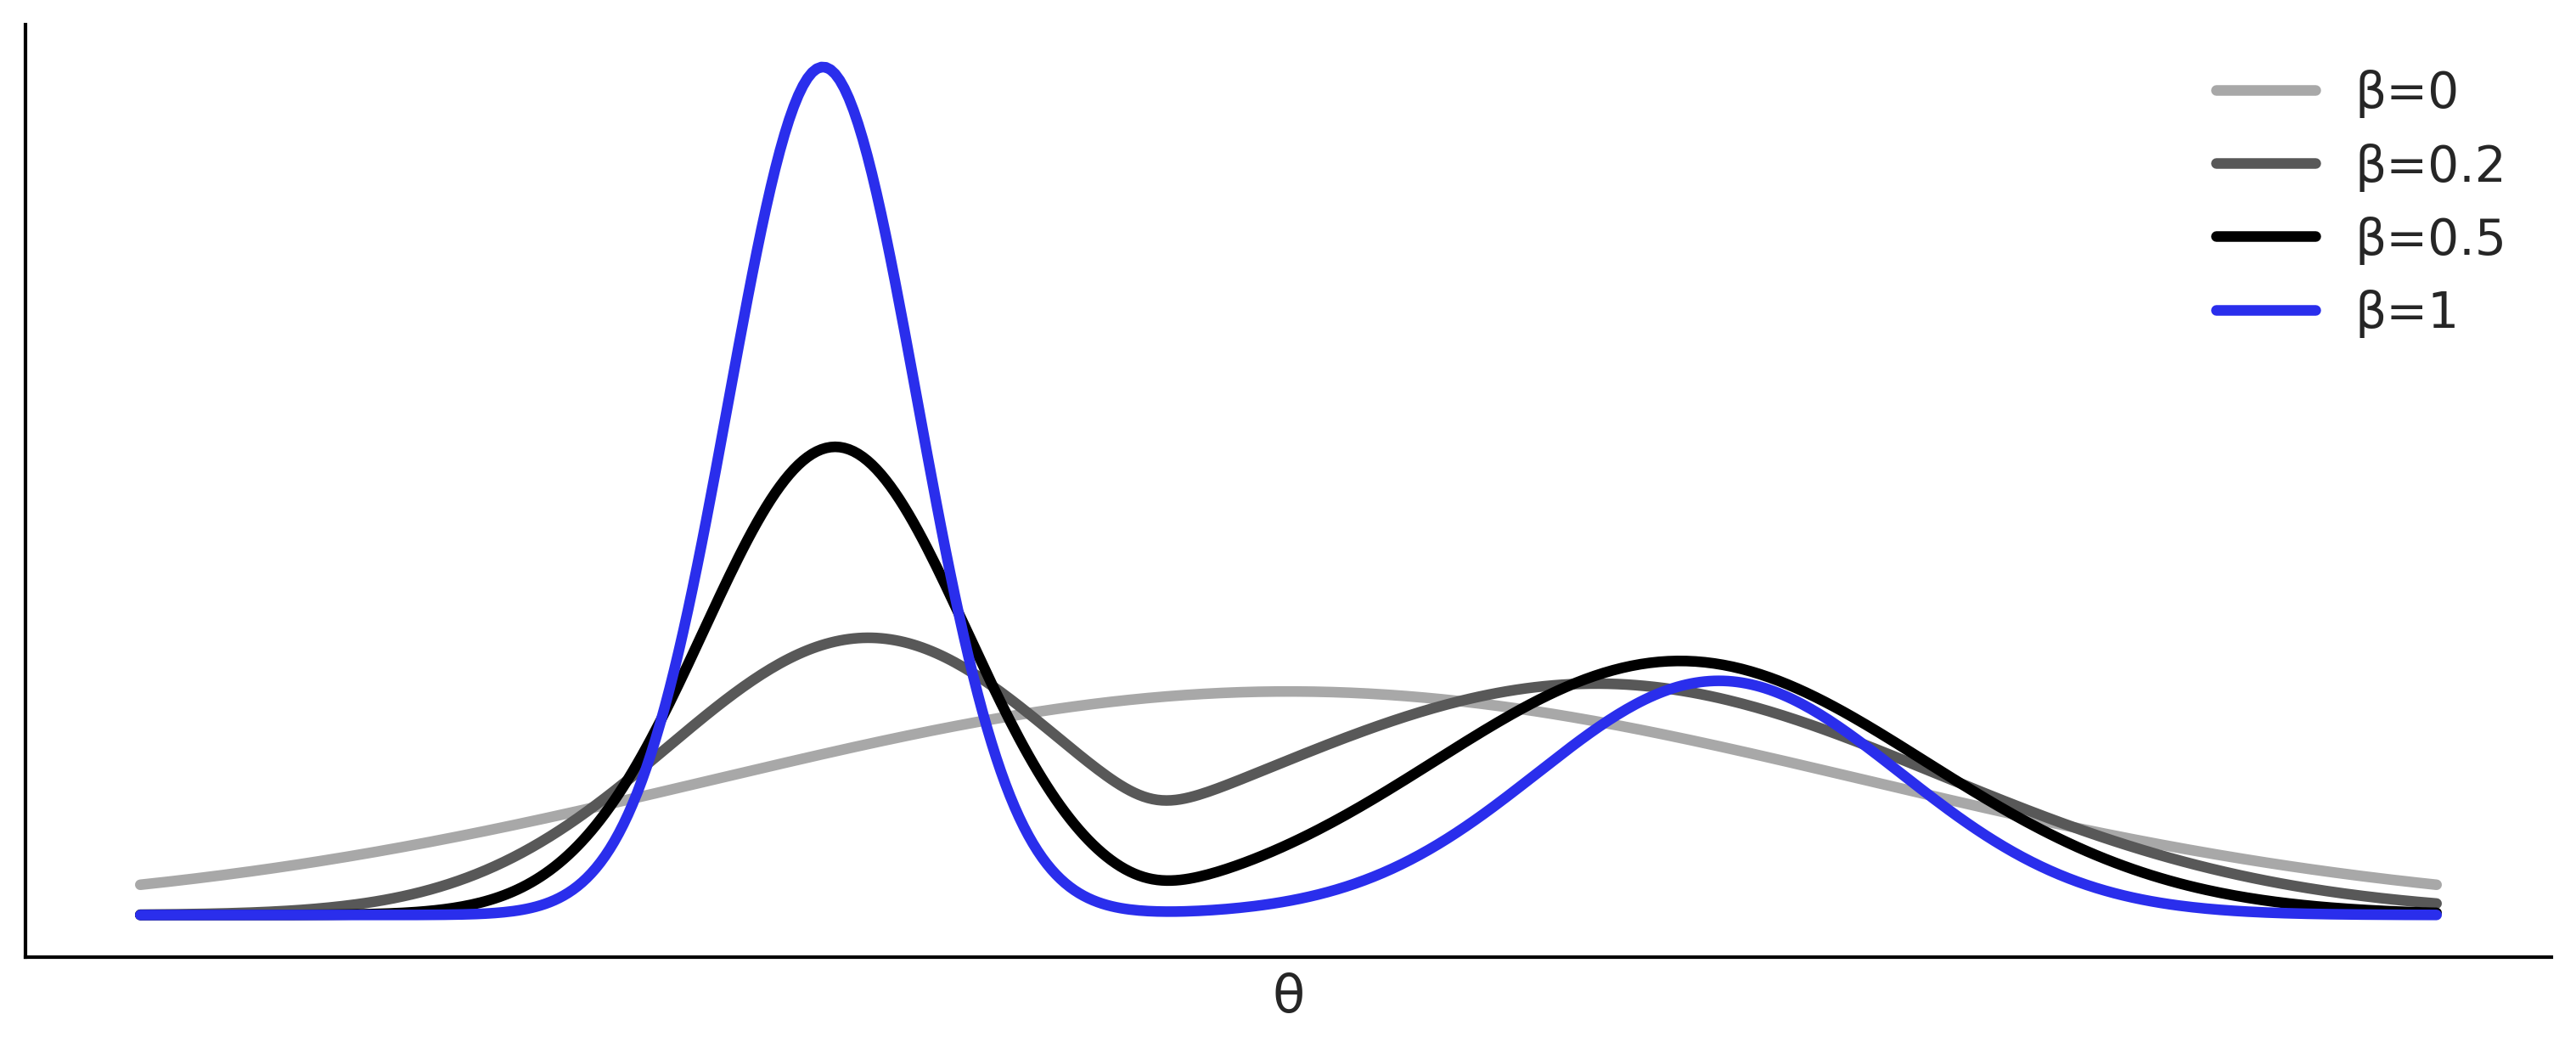

In [3]:
a = stats.norm(-2.5, 0.5)
b = stats.norm(2.5, 1)
c = stats.norm(0, 3)
x = np.linspace(-6, 6, 500)

lpdf = 0.65 * a.pdf(x) + 0.35* b.pdf(x)
ppdf = c.pdf(x)
_, ax = plt.subplots(figsize=(10, 4))
for c, β in zip(["#A8A8A8", "#585858", "#000000", "#2a2eec"],
                [0, 0.2, 0.5, 1]):
    post = ppdf * lpdf**β
    post /= post.sum()
    ax.plot(x, post, lw=3, label=f"β={β}", color=c)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel("θ")
ax.legend()
# plt.savefig("img/chp08/smc_tempering.png")
plt.show();

## 8.3 Fitting a Gaussian the ABC-way
### Standard Likelihood Model

In [4]:
data = np.random.normal(loc=0, scale=1, size=1000)
data[0:4]

array([-0.21227446,  0.63138884, -0.18297731, -0.73768125])

In [5]:
# Standard pymc3 model
with pm.Model() as gauss0:
    μ = pm.Normal("μ", mu=0, sigma=1)
    σ = pm.HalfNormal("σ", sigma=1)
    s = pm.Normal("s", μ, σ, observed=data)
    trace_g0 = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8843681703725781, but should be close to 0.8. Try to increase the number of tuning steps.


In [6]:
with gauss0:
    summ0 = az.summary(trace_g0)
summ0

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ -0.062  0.032  -0.116   -0.001      0.001      0.0    3584.0    2655.0   
σ  1.000  0.022   0.957    1.040      0.000      0.0    3602.0    2916.0   

   r_hat  
μ    1.0  
σ    1.0

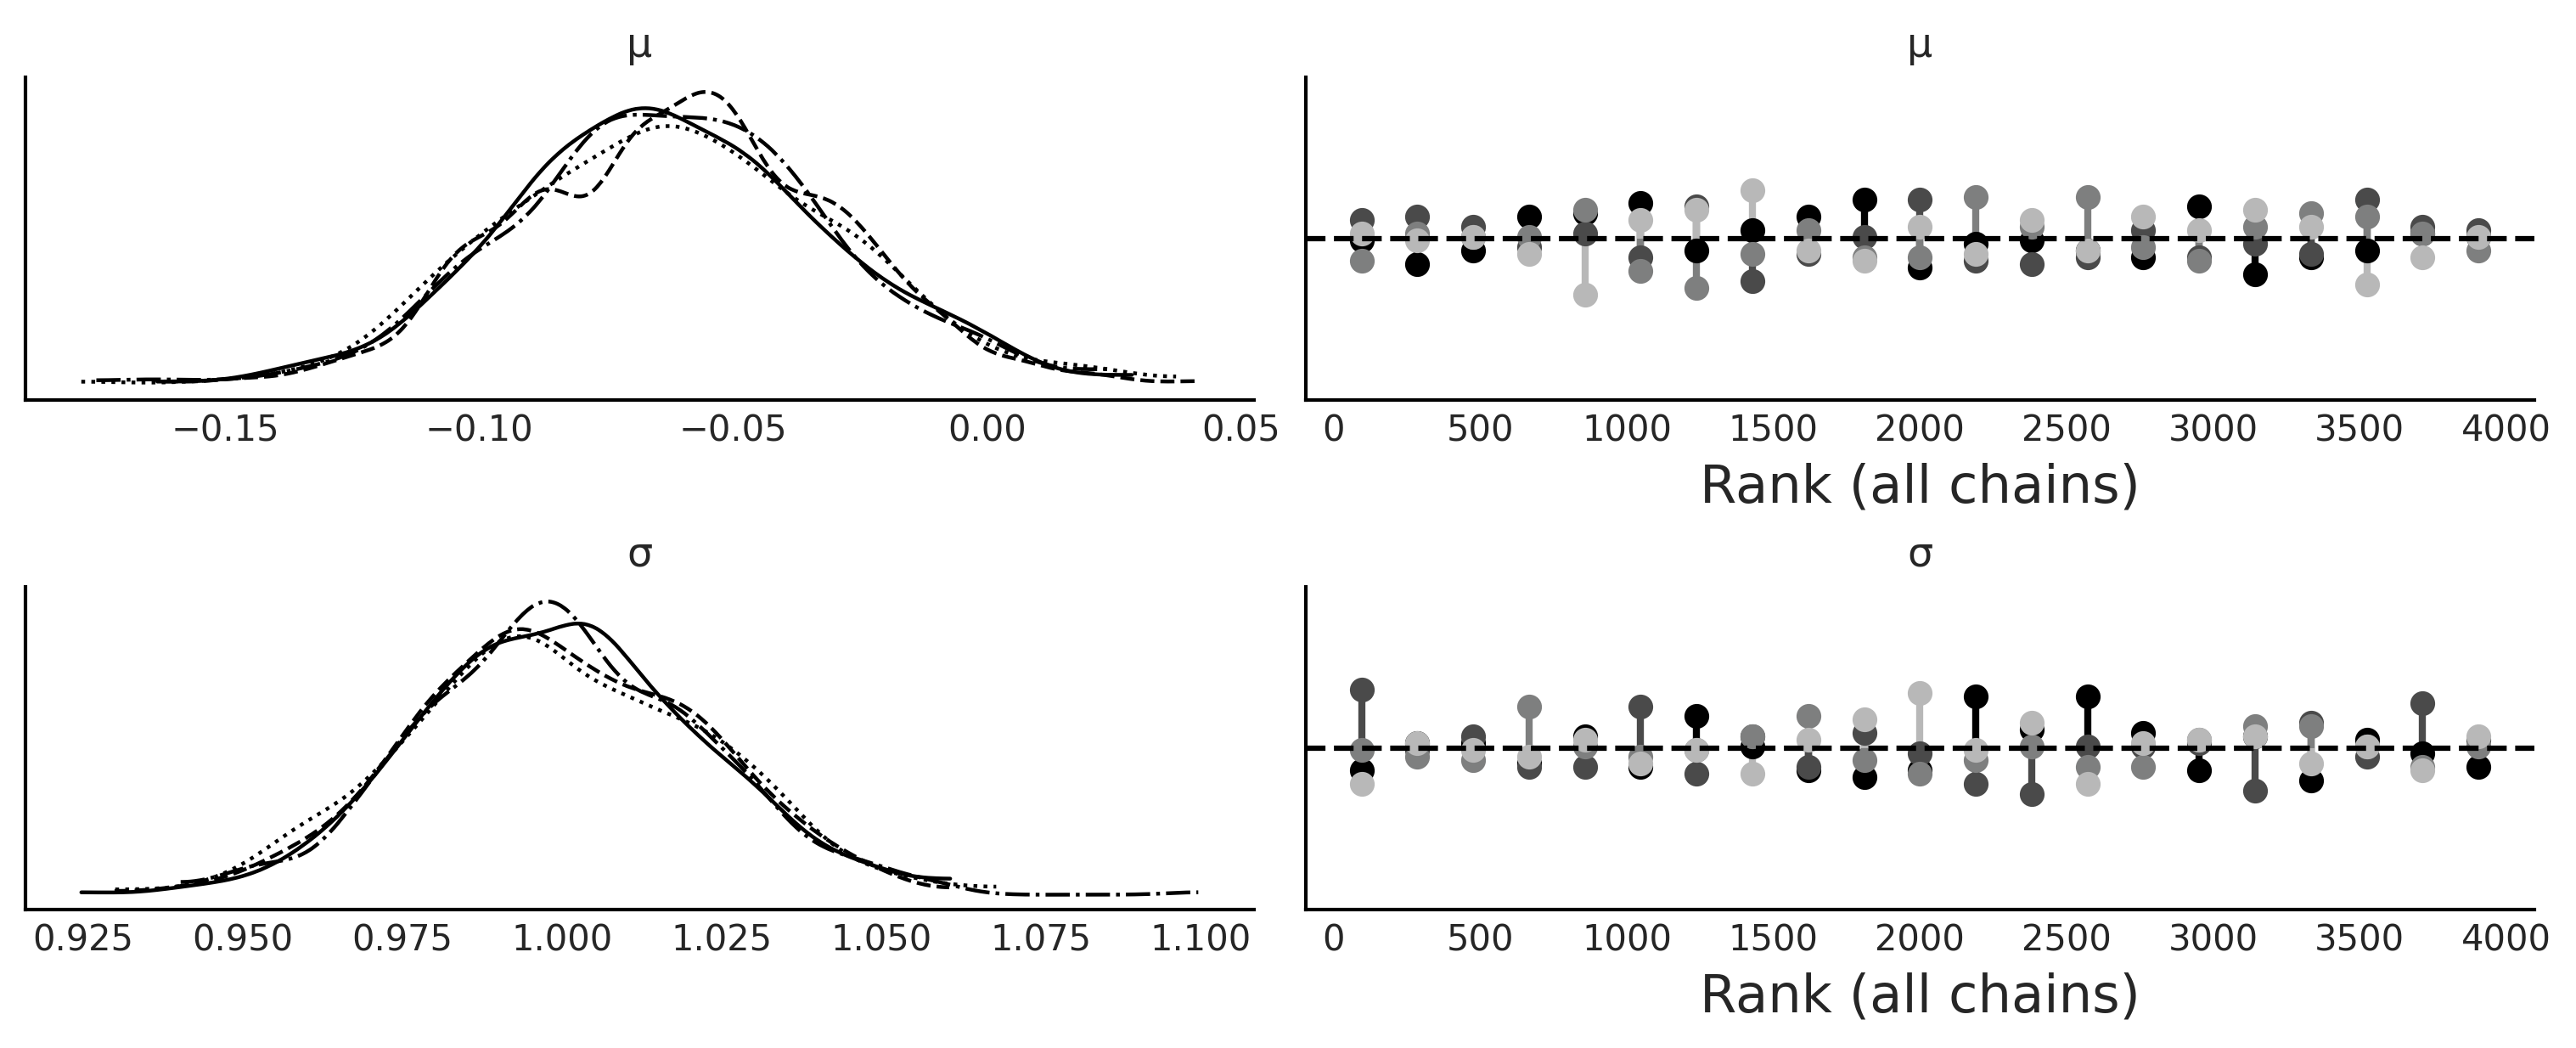

In [7]:
with gauss0:
    az.plot_trace(trace_g0, kind="rank_vlines", figsize=(10, 4));

### Equivalent SMC-ABC - Sequential Monte Carlo Approximate Bayesian Computation

In [8]:
# simulator
def normal_simulator(μ, σ):
    return np.random.normal(μ, σ, 1000)

### Code 8.2 and Figure 8.3

In [9]:
with pm.Model() as gauss:
    μ = pm.Normal('μ', mu=0, sd=1)
    σ = pm.HalfNormal('σ', sd=1)
    # pm.Simulator distribution accepts simulator function and parameter list
    s = pm.Simulator('s', normal_simulator, params=[μ, σ],
                     distance="gaussian", # weighted euclidean distance
                     sum_stat="sort", # sort the data prior to calculating the distance       
                     epsilon=1, # scale of the distamce function
                     observed=data)
    # pm.sample_smc
    trace_g = pm.sample_smc(kernel="ABC",
                            parallel=True)

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.004
Stage:   1 Beta: 0.014
Stage:   2 Beta: 0.049
Stage:   3 Beta: 0.174
Stage:   4 Beta: 0.576
Stage:   5 Beta: 1.000


In [10]:
with gauss:
    summ = az.summary(trace_g)
summ

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ -0.062  0.044  -0.148    0.017        0.0      0.0   12163.0   11568.0   
σ  0.997  0.039   0.924    1.070        0.0      0.0   11727.0   11157.0   

   r_hat  
μ    1.0  
σ    1.0

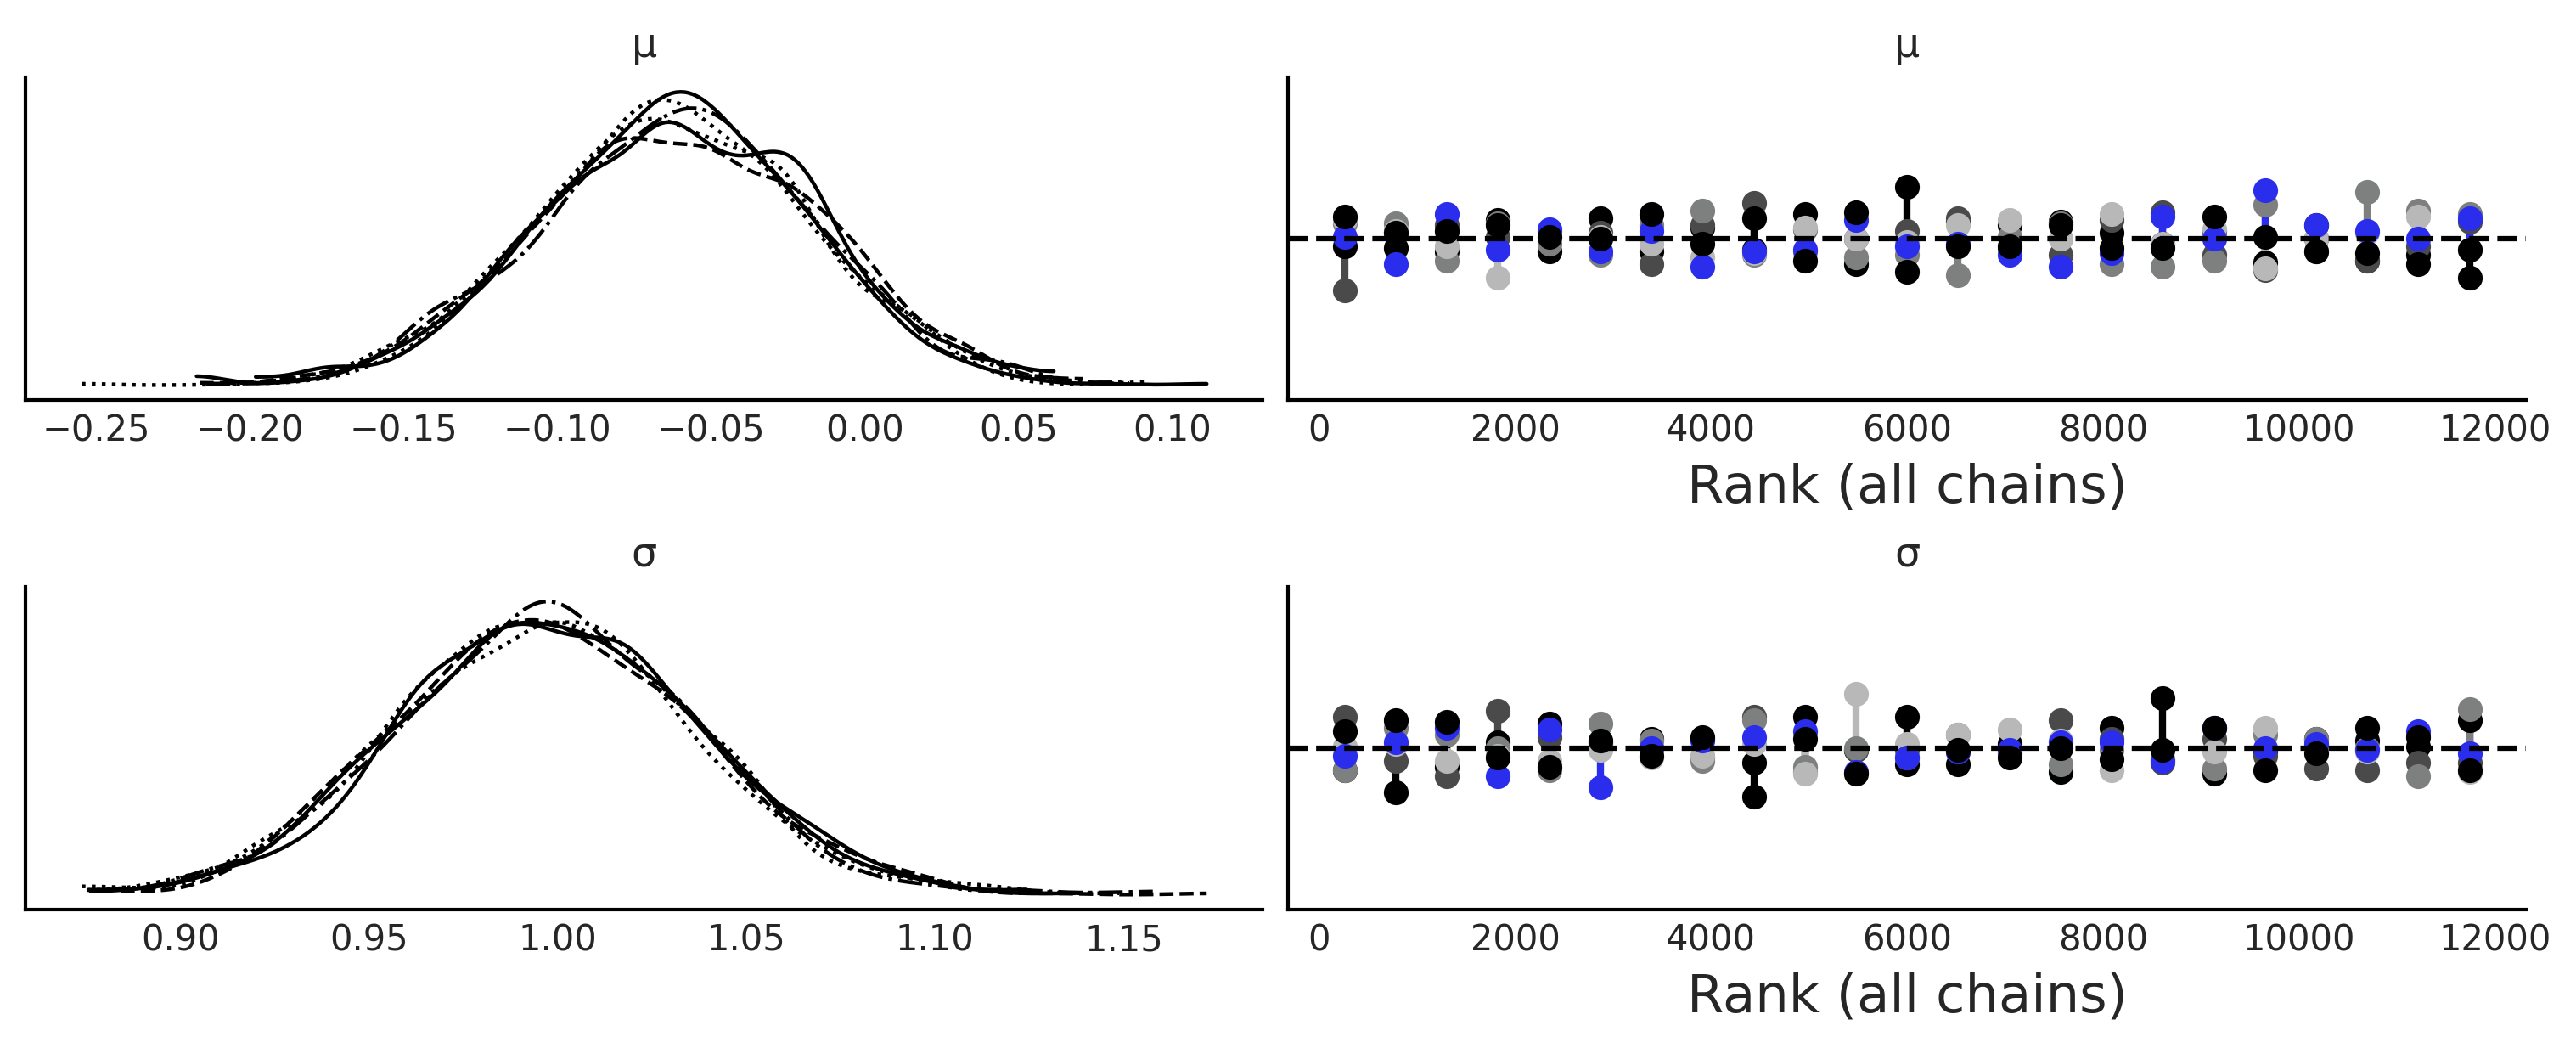

In [11]:
with gauss:
    az.plot_trace(trace_g, kind="rank_vlines", figsize=(10, 4));
# plt.savefig('img/chp08/trace_g.png')

## 8.4 Choosing the Distance Function, $\epsilon$ and the Summary Statistics
+ Selecting these values is problem dependent
+ trial & error approach reqd.
### 8.4.1 Choosing the Distance (Function)
+ `distance="gaussian"` 
+ $\sum -\frac{||X_{oi} - X_{si}||^2}{2\epsilon_i^2}$ - `Gaussian kernel` in log scale 
    + $||X_{oi} - X_{si}||^2$ - the euclidean distance L2 norm
    + With `sum_stat="sort"` the data is sorted prior to computing the distance. Equivalent to 1D 2-Wasserstein distance
    + If we use L1 norm and sort, we get the 1D 1-Wasserstein distance
+ Sorting the data prior to computing distance is the best way to compute the distance, BUT destroys any structure in the data e.g. time series
+ Alternative distance is KL Divergence

#### 8.4.2 Choosing $\epsilon$
+ $\epsilon$ can be (other ppls) a hard threshold - I think this means a single value.
+ pymc3 - $\epsilon$ is the scale of the distance function. For example it could be set to one standard deviation of the observed data.
+ Selecting a scalar value sets the $\epsilon_i$ value to the same for all $i$
+ Using summary statistics, we set $\epsilon$ to a list of values. Have to be careful that this setting does not allow a single summary stat to dominate all the summary stats.
+ Discussion about selecting $\epsilon$, but it seems like this is problem specific and may involve some trial and error.
+ The plots below show how lower $\epsilon$s reduces the range of the hdi distributions.

In [12]:
with pm.Model() as gauss_001:
    μ = pm.Normal('μ', mu=0, sd=1)
    σ = pm.HalfNormal('σ', sd=1)
    s = pm.Simulator('s', normal_simulator, params=[μ, σ],
                     sum_stat="sort",
                     epsilon=0.1,
                     observed=data)
    trace_g_001, sim_data_001 = pm.sample_smc(kernel="ABC",
                                      parallel=True,
                                      save_sim_data=True)

with pm.Model() as gauss_01:
    μ = pm.Normal('μ', mu=0, sd=1)
    σ = pm.HalfNormal('σ', sd=1)
    s = pm.Simulator('s', normal_simulator, params=[μ, σ],
                     sum_stat="sort",
                     epsilon=1,
                     observed=data)
    trace_g_01, sim_data_01 = pm.sample_smc(kernel="ABC",
                                      parallel=True,
                                      save_sim_data=True)
    
with pm.Model() as gauss_02:
    μ = pm.Normal('μ', mu=0, sd=1)
    σ = pm.HalfNormal('σ', sd=1)
    s = pm.Simulator('s', normal_simulator, params=[μ, σ],
                     sum_stat="sort",
                     epsilon=2,
                     observed=data)
    trace_g_02, sim_data_02 = pm.sample_smc(kernel="ABC",
                                      parallel=True,
                                      save_sim_data=True)  
    
with pm.Model() as gauss_05:
    μ = pm.Normal('μ', mu=0, sd=1)
    σ = pm.HalfNormal('σ', sd=1)
    s = pm.Simulator('s', normal_simulator, params=[μ, σ],
                     sum_stat="sort",
                     epsilon=5,
                     observed=data)
    trace_g_05, sim_data_05 = pm.sample_smc(kernel="ABC",
                                      parallel=True,
                                      save_sim_data=True)
    
with pm.Model() as gauss_10:
    μ = pm.Normal('μ', mu=0, sd=1)
    σ = pm.HalfNormal('σ', sd=1)
    s = pm.Simulator('s', normal_simulator, params=[μ, σ],
                     sum_stat="sort",
                     epsilon=10,
                     observed=data)
    trace_g_10, sim_data_10 = pm.sample_smc(kernel="ABC",
                                      parallel=True,
                                      save_sim_data=True)

with pm.Model() as gauss_NUTS:
    μ = pm.Normal('μ', mu=0, sd=1)
    σ = pm.HalfNormal('σ', sd=1)
    s = pm.Normal('s', μ, σ,
                  observed=data)
    trace_g_nuts = pm.sample(return_inferencedata=False)

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.002
Stage:   4 Beta: 0.005
Stage:   5 Beta: 0.016
Stage:   6 Beta: 0.034
Stage:   7 Beta: 0.064
Stage:   8 Beta: 0.113
Stage:   9 Beta: 0.205
Stage:  10 Beta: 0.328
Stage:  11 Beta: 0.461
Stage:  12 Beta: 1.000
Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.014
Stage:   2 Beta: 0.048
Stage:   3 Beta: 0.166
Stage:   4 Beta: 0.549
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.015
Stage:   1 Beta: 0.059
Stage:   2 Beta: 0.203
Stage:   3 Beta: 0.681
Stage:   4 Beta: 1.000
Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.092
Stage:   1 Beta: 0.367
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.366
Stage:   1 Beta: 1.000
Auto-assigning NUTS sampler...
Initializing NUTS usin

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [13]:
idata = az.from_pymc3(trace=trace_g_10)
idata

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


Inference data with groups:
	> posterior
	> log_likelihood
	> observed_data

In [14]:
sim_idata = az.from_dict(sim_data_10)
sim_idata

Inference data with groups:
	> posterior

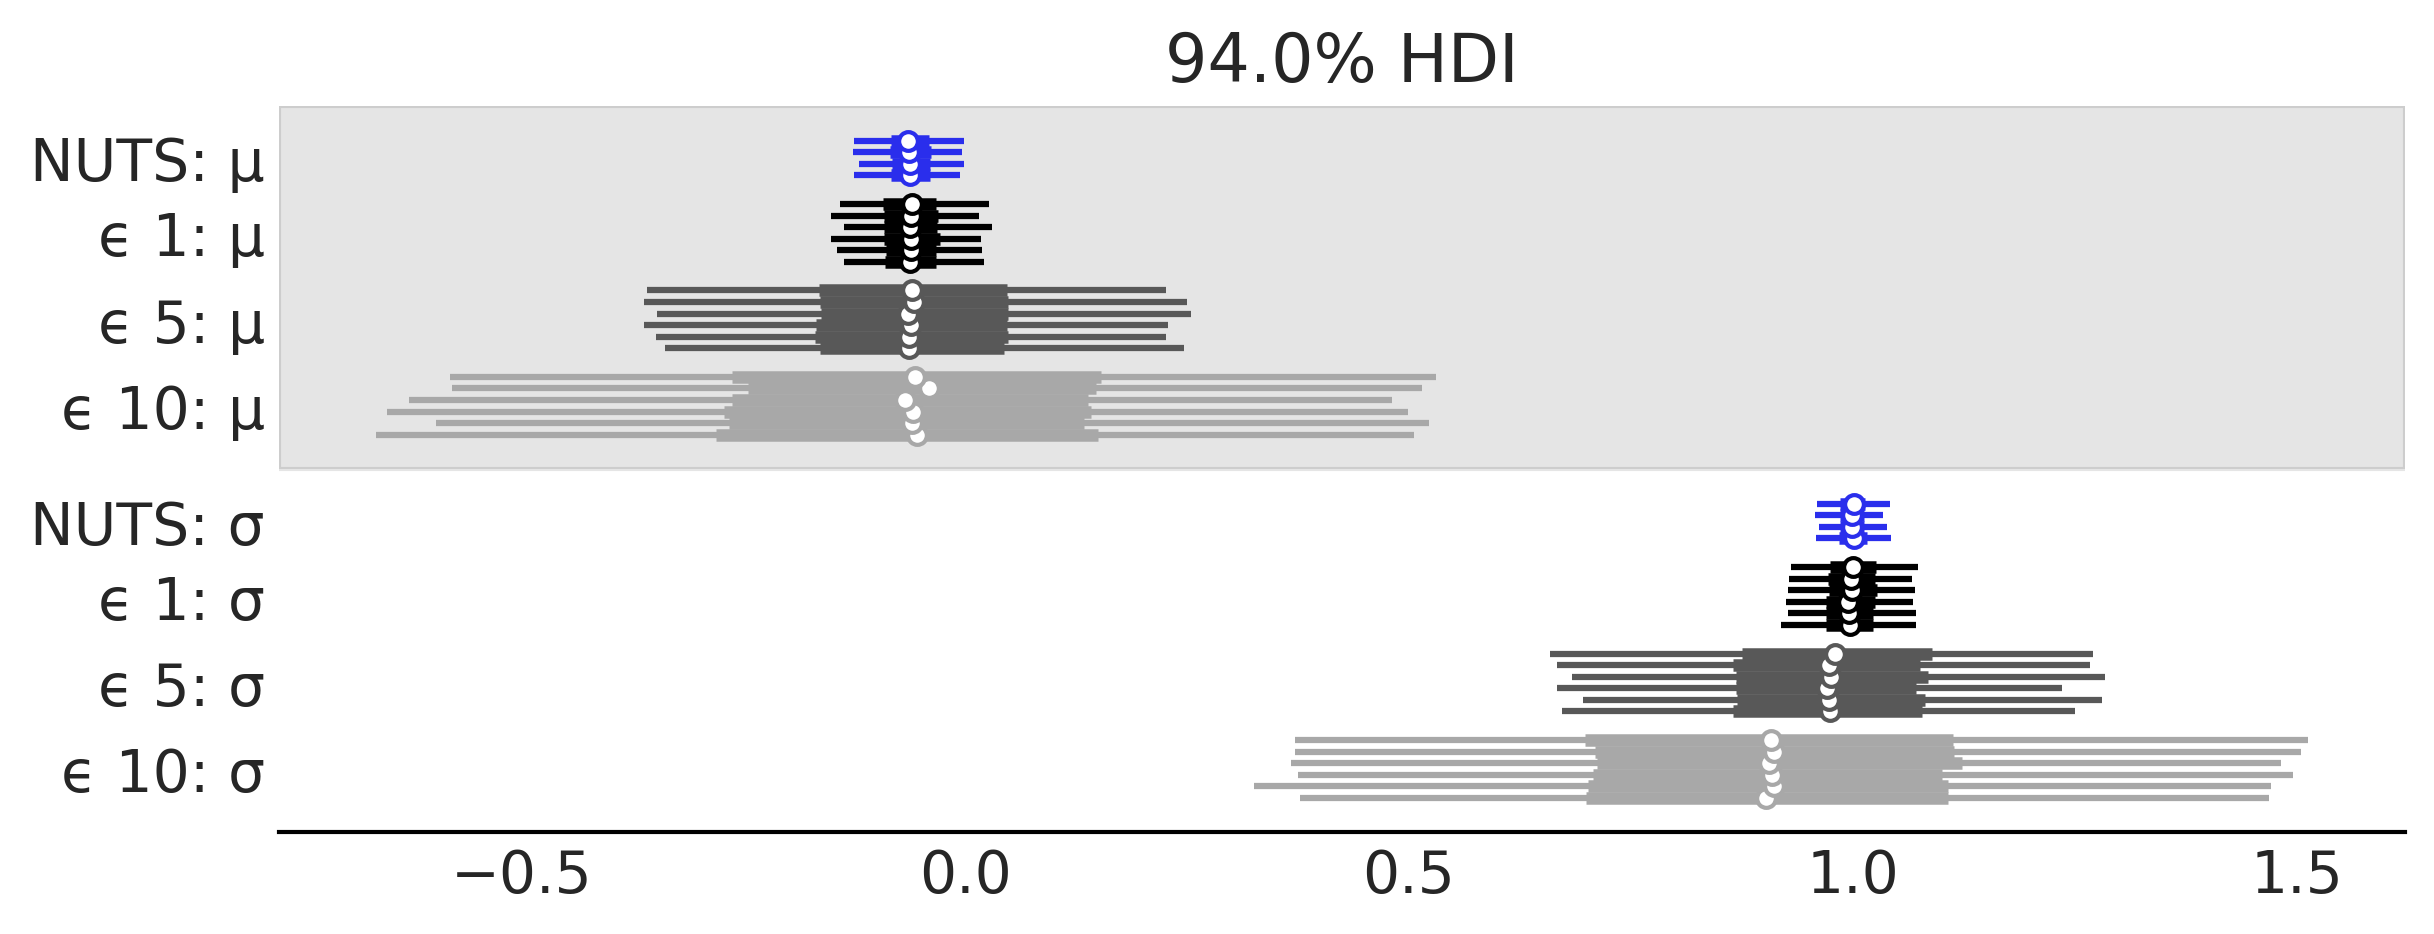

In [15]:
traces = [trace_g_nuts, trace_g_01, trace_g_05, trace_g_10]
az.plot_forest(traces, model_names=["NUTS", "ϵ 1", "ϵ 5", "ϵ 10"],
               colors=["#2a2eec", "#000000", "#585858", "#A8A8A8"],
               figsize=(8, 3));
# plt.savefig("img/chp08/trace_g_many_eps.png")

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


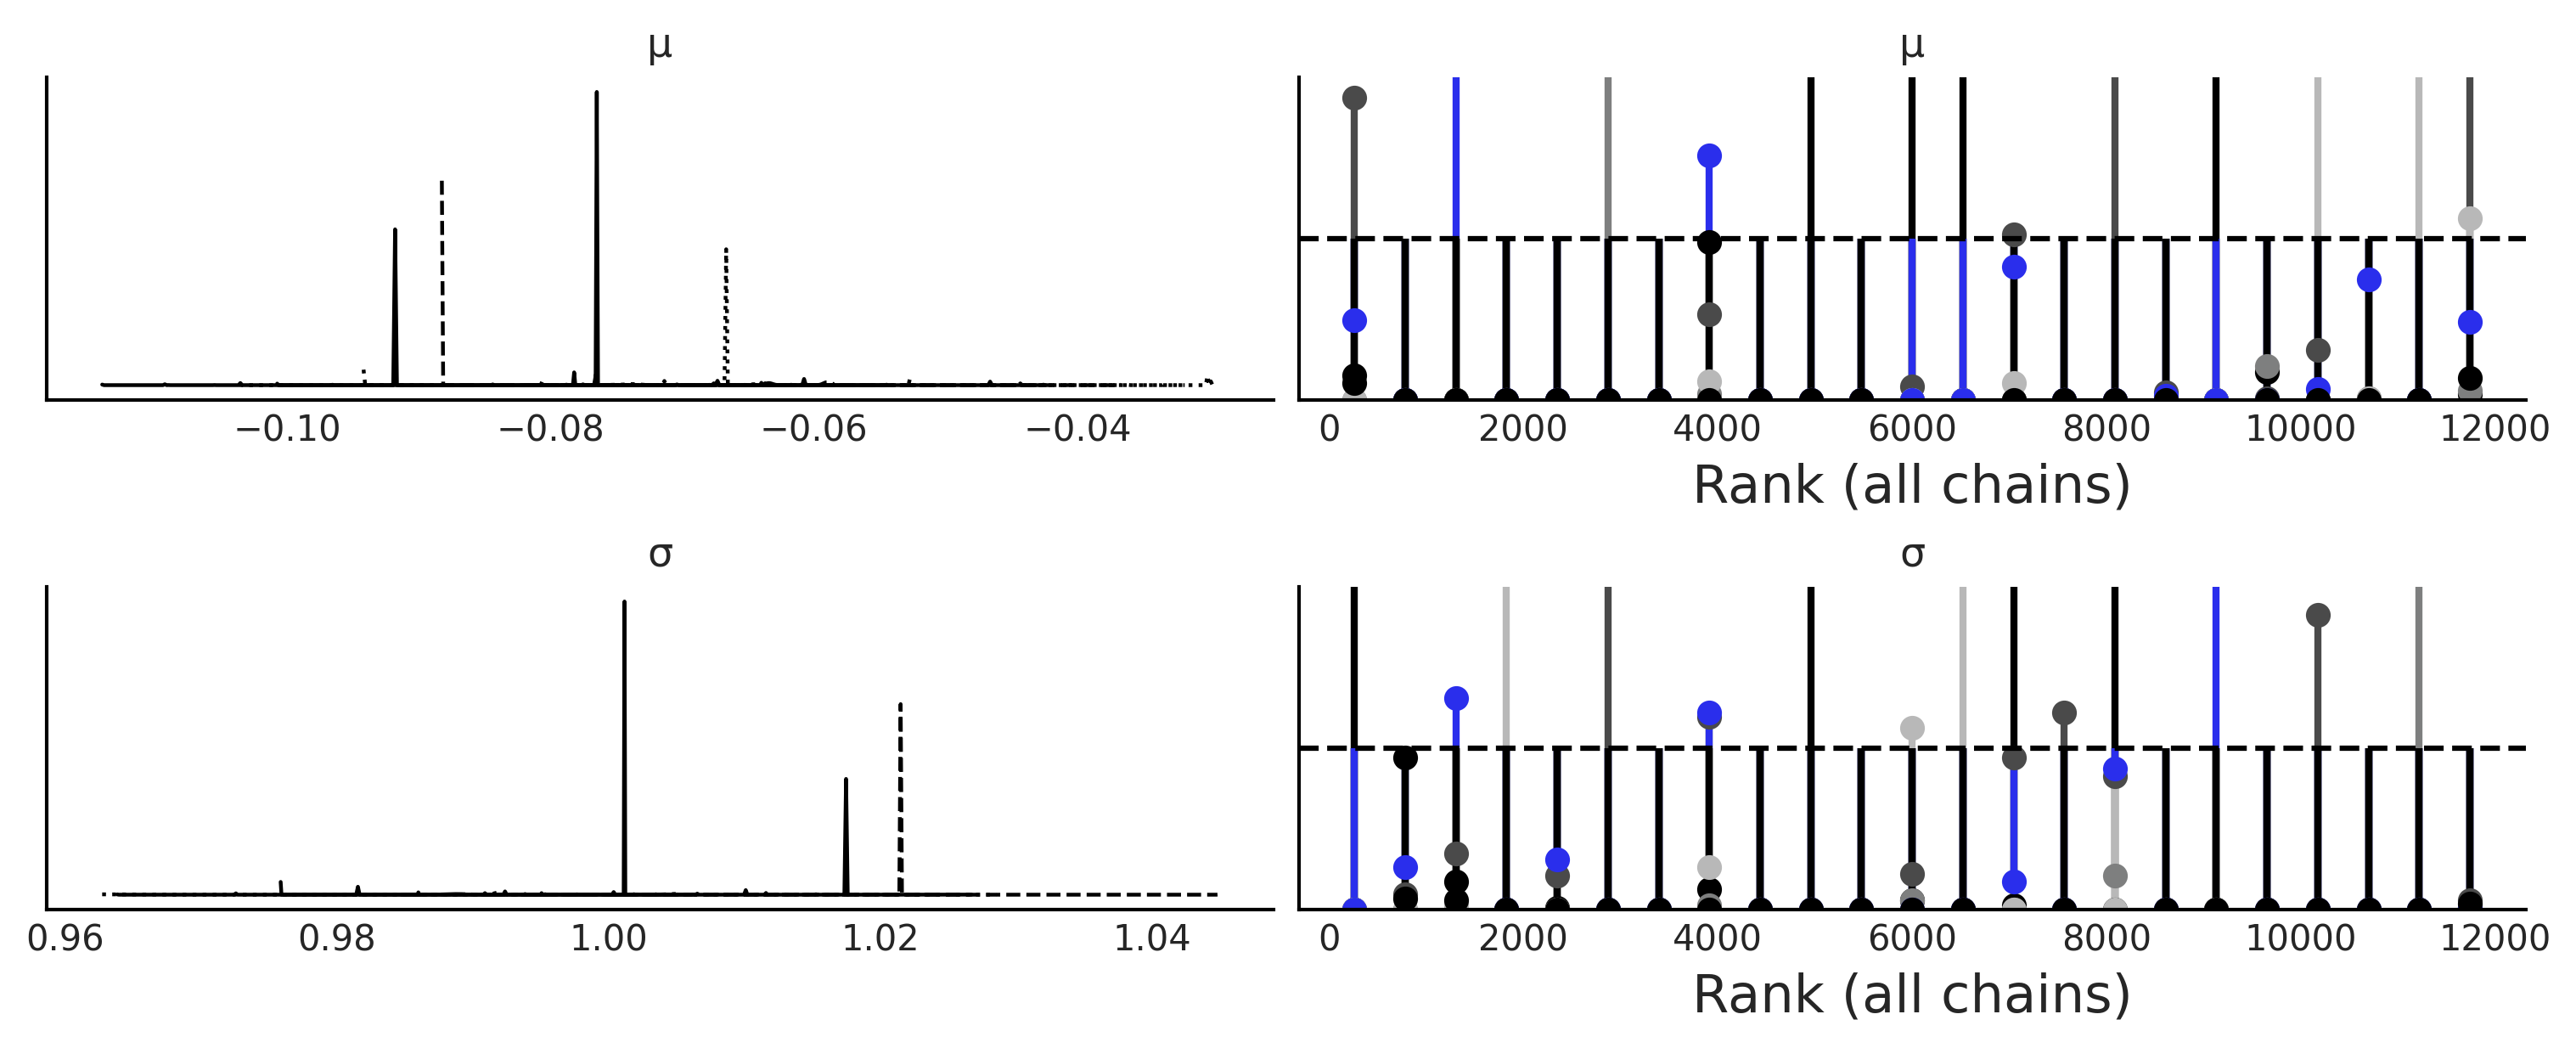

In [16]:
az.plot_trace(trace_g_001, kind="rank_vlines", figsize=(10, 4));
# plt.savefig("img/chp08/trace_g_eps_too_low.png")

### KDE and Rank plot for $epsilon = 0.1$. Failure to converge indicates $\epsilon = 0.1$ is too low

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
/home/d

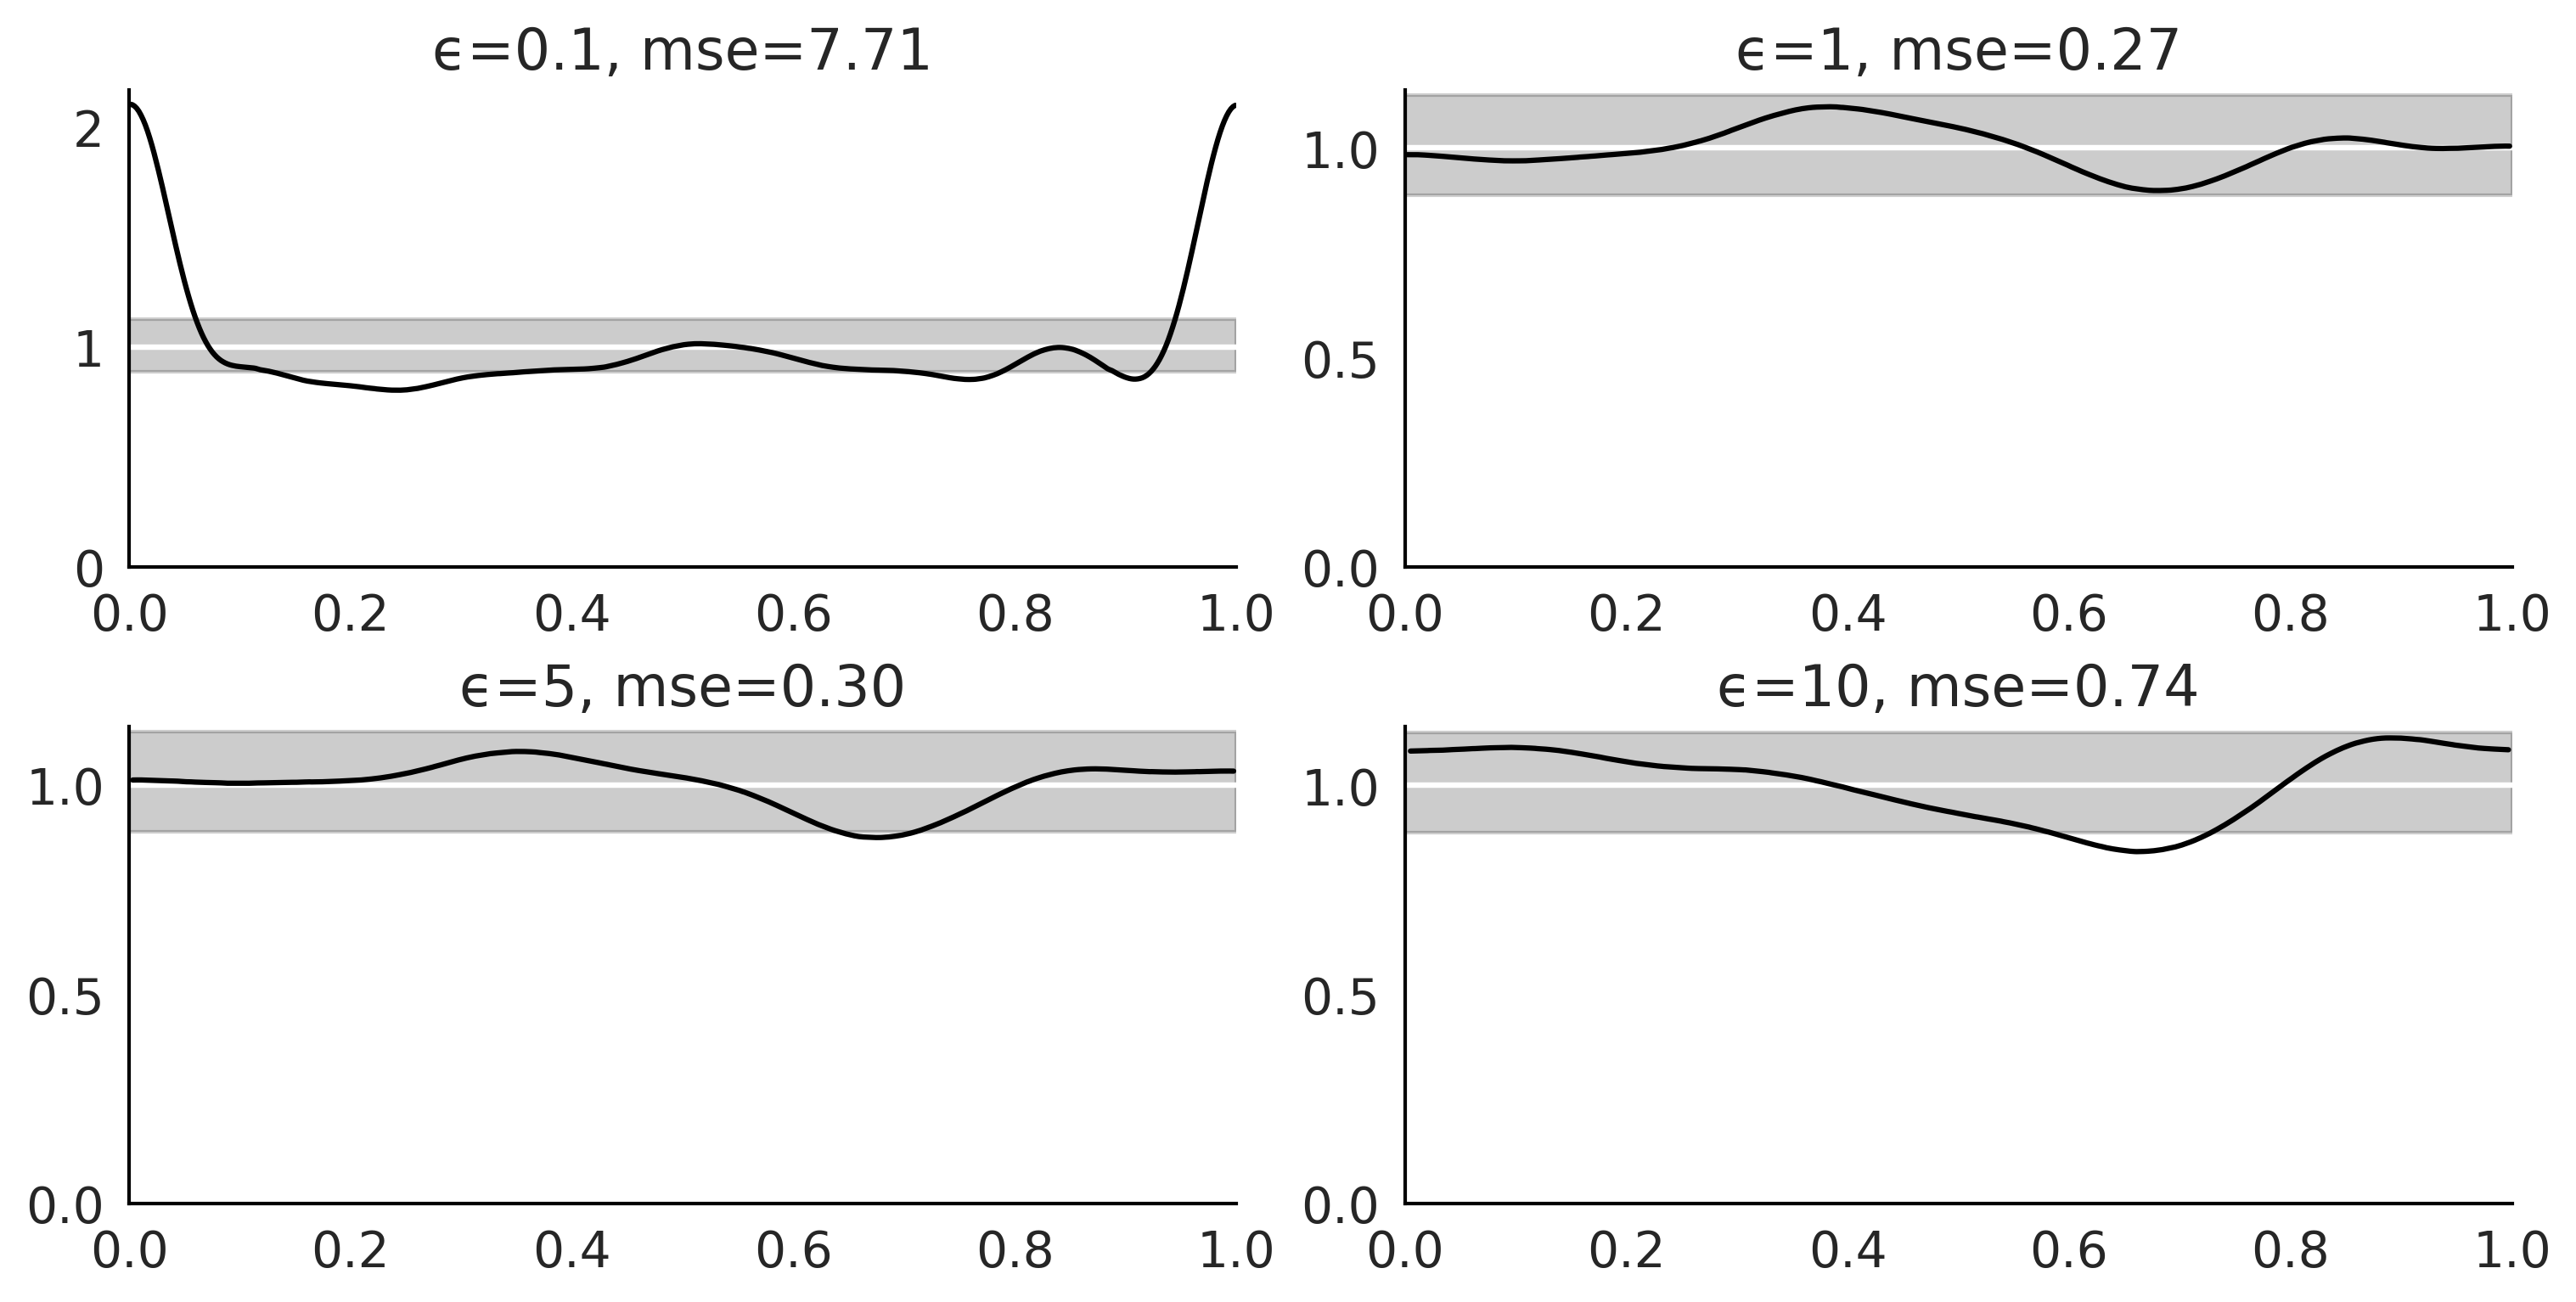

In [17]:
traces_ = [trace_g_001, trace_g_01, trace_g_05, trace_g_10]
sim_data_ = [sim_data_001, sim_data_01, sim_data_05, sim_data_10]
epsilons = [0.1, 1, 5, 10]

_, axes = plt.subplots(2, 2, figsize=(10,5))

for i, ax in enumerate(axes.ravel()):
    dada = az.from_pymc3(traces_[i], 
                         posterior_predictive=sim_data_[i])

    #pp_vals = np.reshape(sim_data_[i]["s"], (8000, -1))
    pp_vals = np.reshape(sim_data_[i]["s"], (12000, -1)) # n_chains x n_draws

    tstat_pit = np.mean(pp_vals <= data, axis=0)
    _, tstat_pit_dens = az.kde(tstat_pit)
    
    ax.axhline(1, color="w")
    az.plot_bpv(dada, kind="u_value", ax=ax, reference="analytical")
    ax.tick_params(axis='both', pad=7)
    ax.set_title(f"ϵ={epsilons[i]}, mse={np.mean((1 - tstat_pit_dens)**2) * 100:.2f}")

# plt.savefig("img/chp08/bpv_g_many_eps_00.png")
plt.show();

### Distribution of marginal p-values for increasing values of $\epsilon$
+ Well calibrated model should exhibit a Uniform distribution
+ $\epsilon = 0.1$ calibration very poor - $\epsilon$ is too low
+ Other $\epsilon$s the distributions are closer to Uniform
+ `mse` values are the scaled squared differences between the expected Uniform distribution and the compted KDEs

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
/home/d

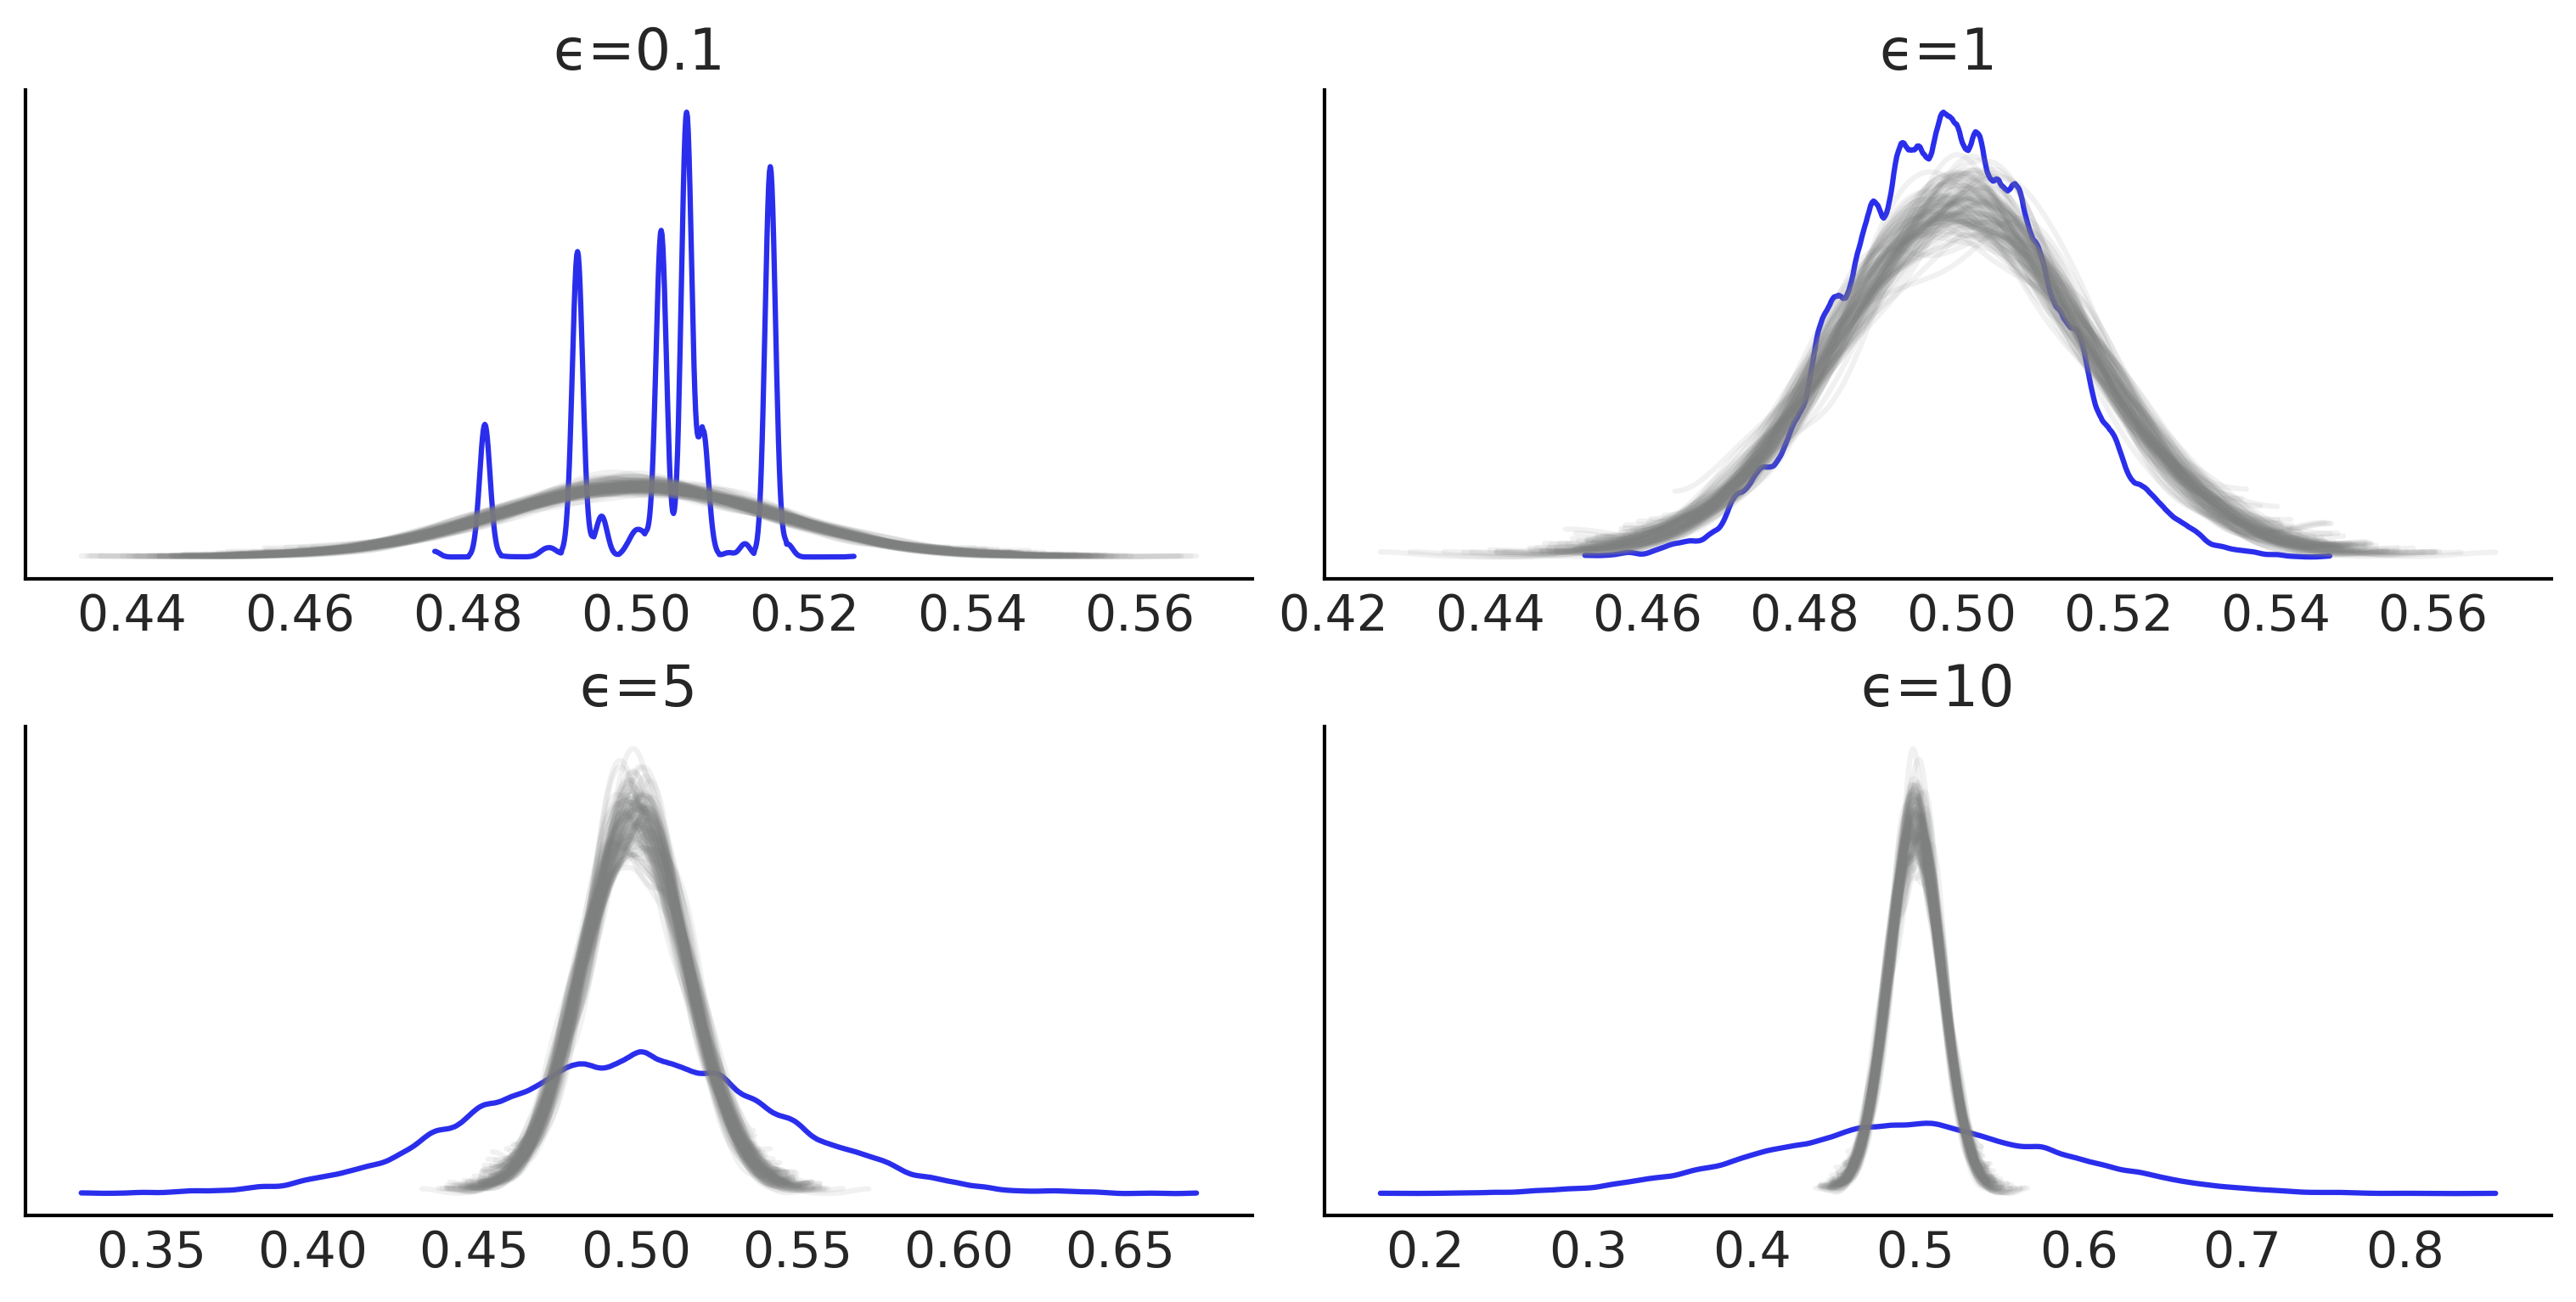

In [18]:
_, ax = plt.subplots(2, 2, figsize=(10,5))

ax = ax.ravel()
for i in range(4):
    dada = az.from_pymc3(traces_[i], 
                         posterior_predictive=sim_data_[i])

    az.plot_bpv(dada, kind="p_value", reference='samples', color="C4", ax=ax[i],
               plot_ref_kwargs={"color":"C2"})
    ax[i].set_title(f"ϵ={epsilons[i]}")
# plt.savefig("img/chp08/bpv_g_many_eps_01.png")
plt.show();

### Bayesian p-values for Increasing values of $\epsilon$
+ Blue curve is observed distribution
+ Gray curves are expected distributions
+ Well calibrated model should show a distribution concentrated around 0.5
+ $\epsilon = 0.1$ calibration very poor - $\epsilon$ is too low
+ $\epsilon = 1$ has the best result

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
/home/d

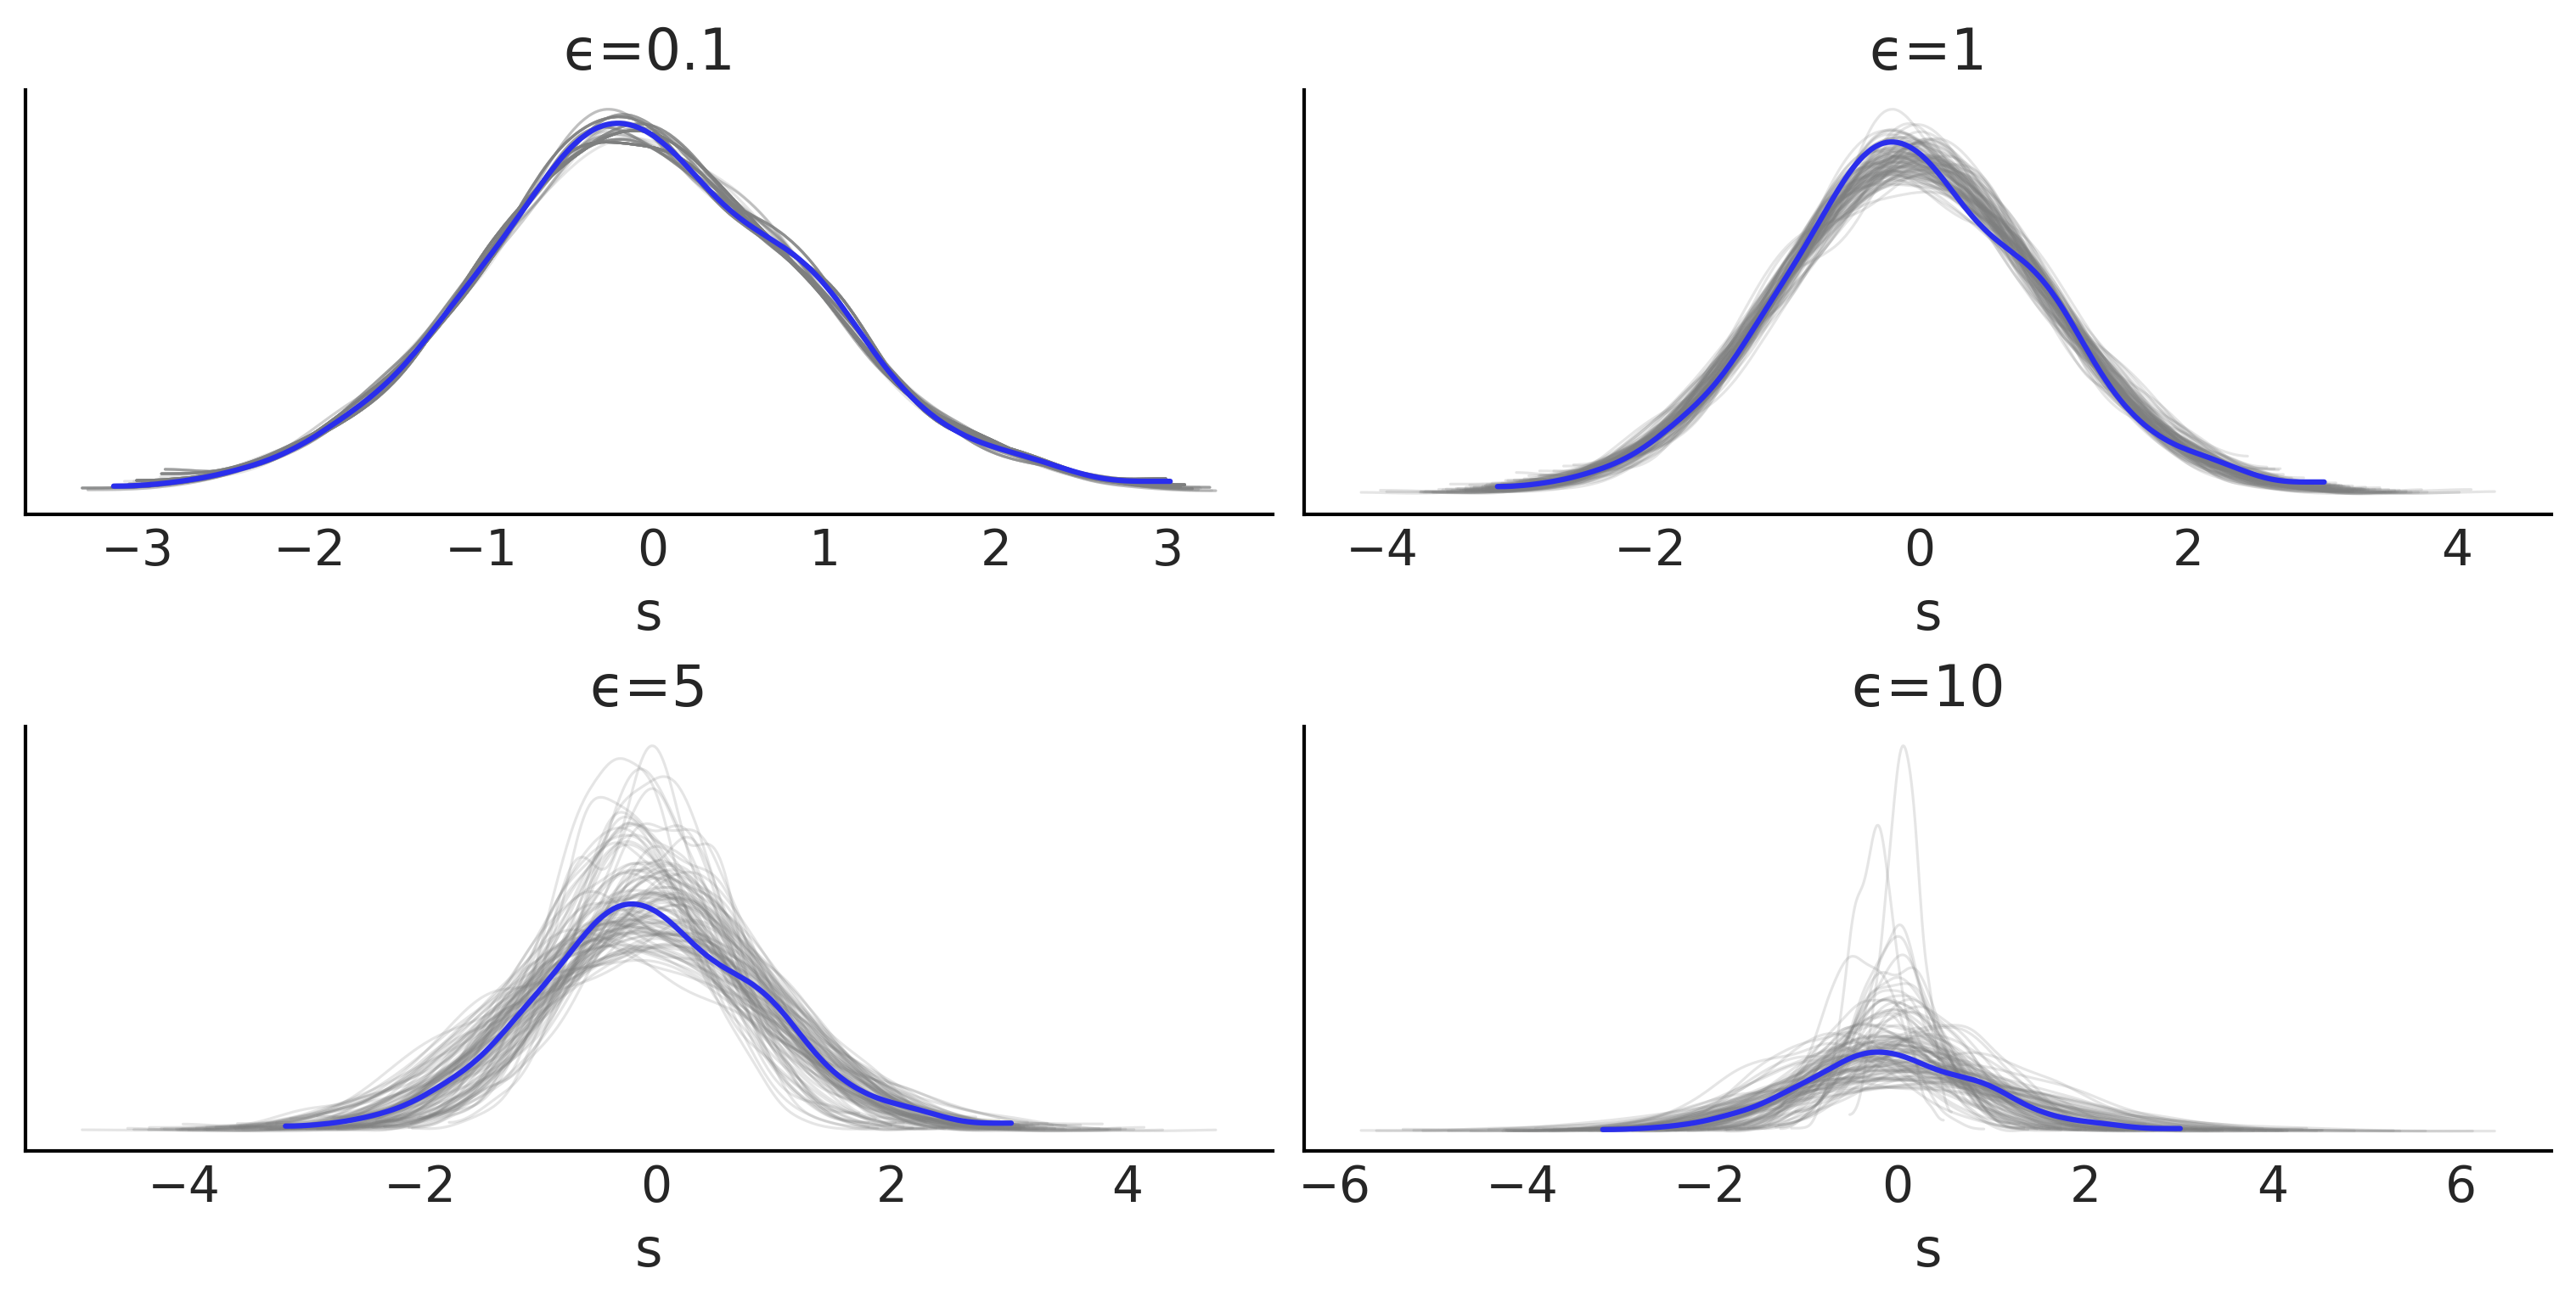

In [19]:
_, axes = plt.subplots(2, 2, figsize=(10,5))

for i, ax in enumerate(axes.ravel()):
    dada = az.from_pymc3(traces_[i], 
                         posterior_predictive=sim_data_[i])

    az.plot_ppc(dada, num_pp_samples=100, ax=ax, color="C2",
                mean=False, legend=False, observed=False)
    az.plot_kde(dada.observed_data["s"], plot_kwargs={"color":"C4"}, ax=ax)
    ax.set_xlabel("s")
    ax.set_title(f"ϵ={epsilons[i]}")
# plt.savefig("img/chp08/ppc_g_many_eps.png")
plt.show()

### Posterior Checks for Increasing values of $\epsilon$
+ $\epsilon = 0.1$ shows good adjustment. This is an illusion - too good to be true
+ $\epsilon = 1$ has the best result

## 8.5 g-and-k distributions
+ Daily CO levels at one station in Buenos Aires 2010-2018
+ data is heavily skewed

In [20]:
data = pd.read_csv("data/air_pollution_bsas.csv")
bsas_co = data["co"].dropna().values
bsas_co

array([0.539     , 0.669     , 0.3225    , ..., 0.63458333, 0.7125    ,
       0.4975    ])

In [21]:
print(bsas_co.shape)
# Without extreme right tail values
bsas_ = bsas_co[bsas_co < 3.0]
print(bsas_.shape)

(2484,)
(2476,)


'We have 8 observations larger than 3 ppm'

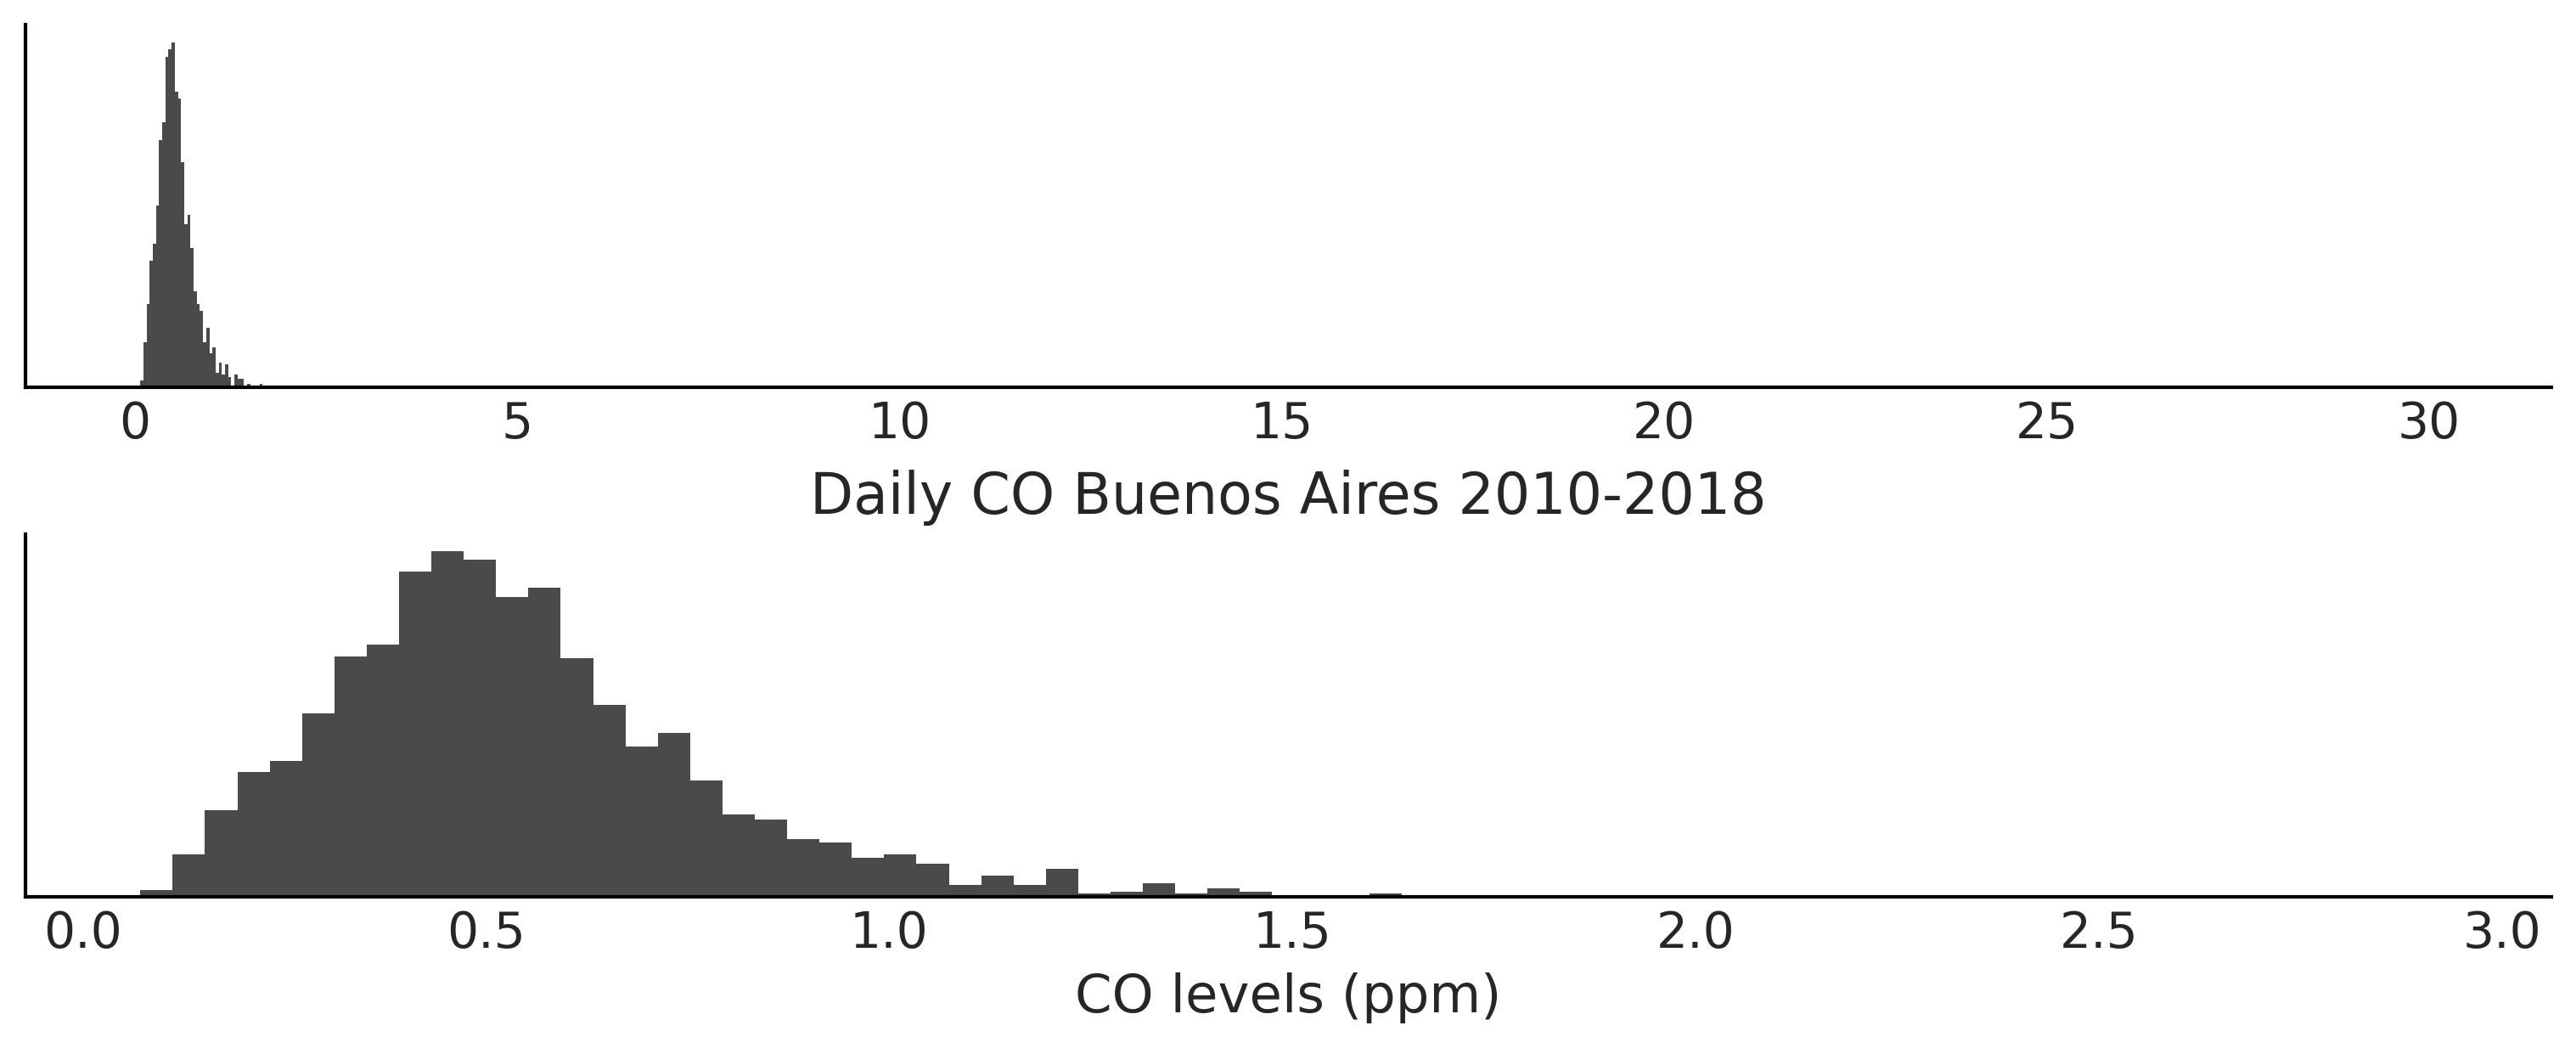

In [22]:
_, axes = plt.subplots(2,1,  figsize=(10,4), sharey=True)
axes[0].hist(bsas_co, bins="auto", color="C1", density=True)
axes[0].set_yticks([])
axes[1].hist(bsas_co[bsas_co < 3], bins="auto", color="C1", density=True)
axes[1].set_yticks([])
axes[1].set_xlabel("CO levels (ppm)")
# plt.savefig("img/chp08/co_ppm_bsas.png")
plt.title('Daily CO Buenos Aires 2010-2018')
f"We have {sum(bsas_co > 3)} observations larger than 3 ppm"

+ Data will be fitted to a univariate g-and-k distribution
+ 4 parameter distribution with high skewness and/or kurtosis
+ Density function not available in closed form, so cannot perform likelihood inference
+ g-and-k CDF: $a + b(1 +c\tanh[\frac{gz(x)}{2}])(1 + z(x)^2)^kz(x)$
+ parameters:
    + a - location
    + b - scale
    + g - skewness
    + k - kurtosis
    + If g and k = 0, we get a gaussian of mean a and standard deviation b
    + g > 0 positive (right) skewness | g < 0 negative (left) skewness
    + k > 0 longer than normal tails | k < 0 shorter than normal tails
    + Common to restrict b to +ve and k >= -0.5 or sometimes k >=0 ie tails same or heavier than normal distribution
    + Common to fix c=0.8
    + These restrictions guarantee a strictly increasing quantile function - hallmark of welll defined continuous distribution functions
    

In [23]:
class g_and_k_quantile:
    def __init__(self):
        self.quantile_normal = stats.norm(0, 1).ppf
        self.pdf_normal = stats.norm(0, 1).pdf

    def ppf(self, x, a, b, g, k):
        z = self.quantile_normal(x)
        return a + b * (1 + 0.8 * np.tanh(g*z/2)) * ((1 + z**2)**k) * z

    
    def rvs(self, samples, a, b, g, k):
        x = np.random.uniform(0, 1, samples)
        return self.ppf(x, a, b, g, k)

    def cdf(self, x, a, b, g, k, zscale=False):   
        optimize.fminbound(f, -5, 5)

    def pdf(self, x, a, b, g, k):
        #z = cdf(x, a, b, g, k)
        z = x
        z_sq = z**2
        term1 = (1+z_sq)**k
        term2 = 1+0.8*np.tanh(g*x/2)
        term3 = (1+(2*k+1)*z_sq)/(1+z_sq)
        term4 = 0.8*g*z/(2*np.cosh(g*z/2)**2)

        deriv = b*term1*(term2*term3+term4)
        return self.pdf_normal(x) / deriv

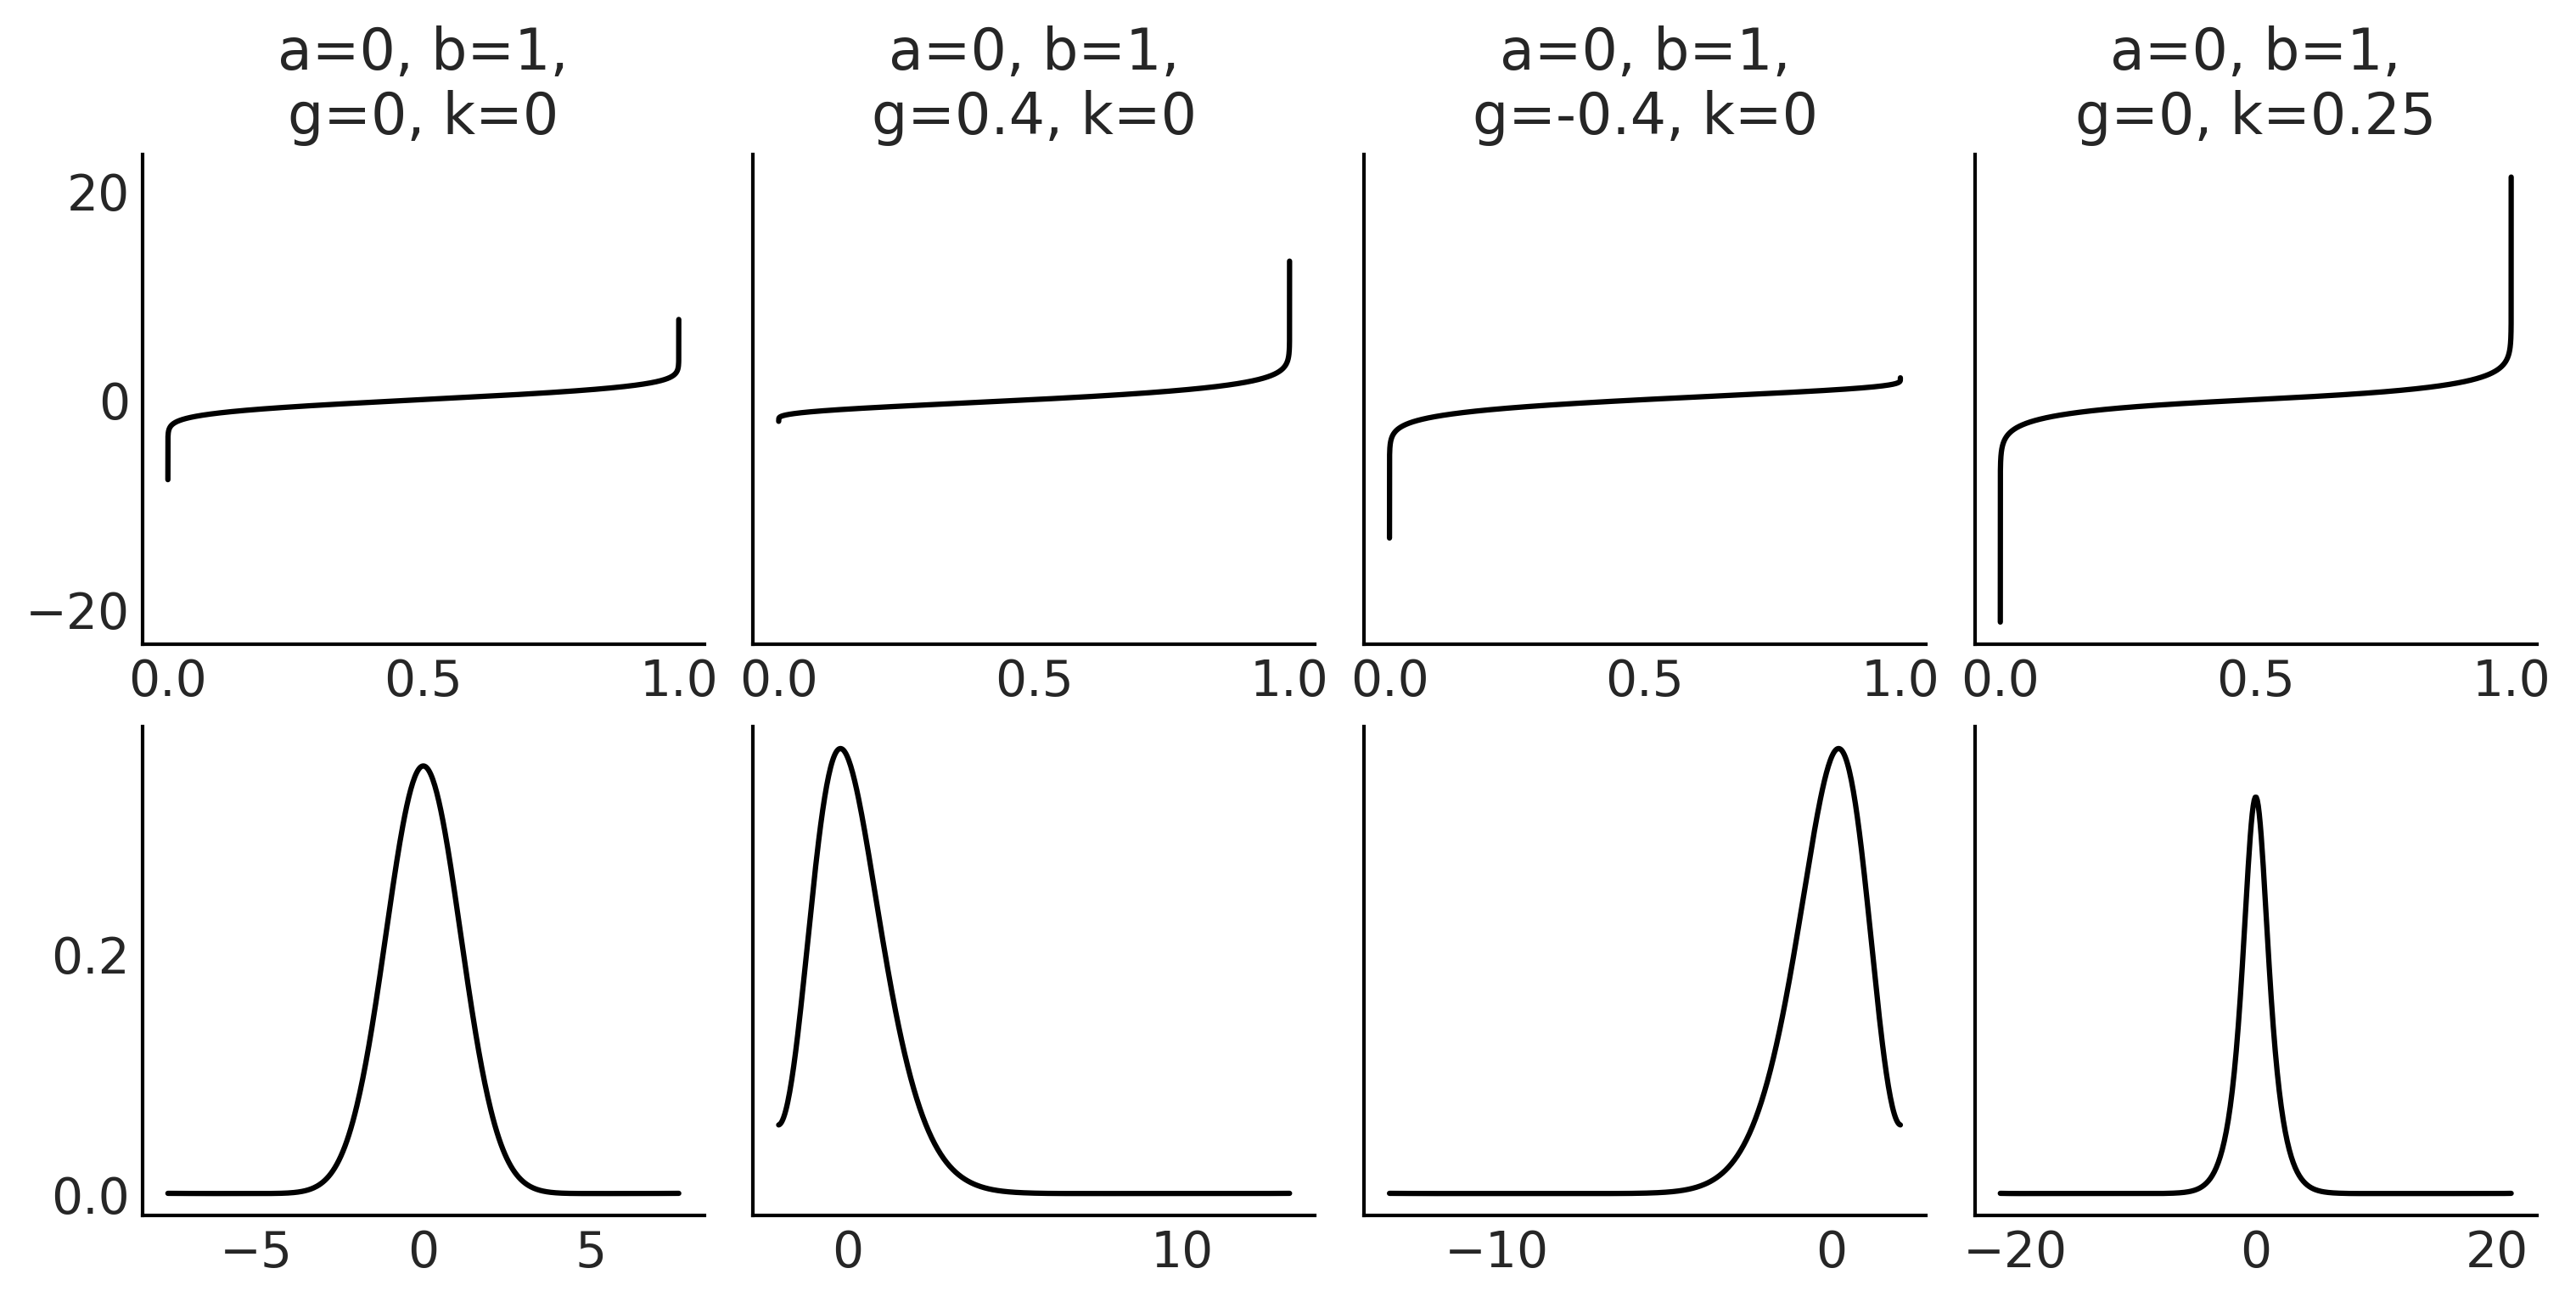

In [24]:
gk = g_and_k_quantile()
u = np.linspace(1E-14, 1-1E-14, 10000)

params = ((0, 1, 0, 0), 
 (0, 1, .4, 0),
 (0, 1,-.4, 0),
 (0, 1, 0, 0.25))

_, ax = plt.subplots(2, 4, sharey="row", figsize=(10, 5))
for i, p in enumerate(params):
    a, b, g, k = p
    ppf = gk.ppf(u, a, b, g, k)
    ax[0, i].plot(u, ppf)
    ax[0, i].set_title(f"a={a}, b={b},\ng={g}, k={k}")
    #ax[1, i].plot(x, gk.pdf(x, a, b, g, k))
    az.plot_kde(ppf, ax=ax[1, i], bw=0.5)
# plt.savefig("img/chp08/gk_quantile.png")

### g-and-k parameterization
+ First row - Quantile function (inverse of cumulative distribution function)
+ second row - probability density function

### Fitting the g-and-k distribution - Summary stats
+ Use gaussian distance
+ `sum_stat="sort"`
+ Consider $e1$ to $e7$ octiles - ie quantiles that divide a sample into 8 subsets. So e4 relates to the mean
+ Robust estimators defined below
    + $sa = e4$ - location -e4 is the median
    + $sb = e6 - e2$ - scale/standard deviation - interquartile range
    + $sg = (e6 + e2 -2*e4)/sb$ - skewness - robust estimator as laid out in text
    + $sk = (e7 -e5 + e3 -e1)/sb$ - kurtosis - as above

In [25]:
def octo_summary(x):
    e1, e2, e3, e4, e5, e6, e7 = np.quantile(x, [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875])
    sa = e4
    sb = e6 - e2
    sg = (e6 + e2 - 2*e4)/sb
    sk = (e7 - e5 + e3 - e1)/sb
    return np.array([sa, sb, sg, sk])

### Simulator Function
+ Class & rvs method

In [26]:
gk = g_and_k_quantile()
def gk_simulator(a, b, g, k):
    return gk.rvs(len(bsas_co), a, b, g, k)

### ABC-SMC Model

In [27]:
with pm.Model() as gkm:
    a = pm.HalfNormal('a', sd=1)
    b = pm.HalfNormal('b', sd=1)
    g = pm.HalfNormal('g', sd=1)
    k = pm.HalfNormal('k', sd=1)
    
    s = pm.Simulator('s', gk_simulator, params=[a, b, g, k],        
                     sum_stat=octo_summary,
                     epsilon=0.1,
                     observed=bsas_co)
    
    trace_gk, sim_data_gk = pm.sample_smc(kernel="ABC",
                                          parallel=True,
                                          save_sim_data=True,
                                          )

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.012
Stage:   1 Beta: 0.068
Stage:   2 Beta: 0.236
Stage:   3 Beta: 0.663
Stage:   4 Beta: 1.000


In [28]:
az.summary(trace_gk)

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a  0.504  0.100   0.320    0.698      0.001    0.001   12249.0   12065.0   
b  0.195  0.070   0.069    0.334      0.001    0.000   11608.0   11628.0   
g  0.457  0.292   0.000    0.962      0.003    0.002   12093.0   11460.0   
k  0.144  0.087   0.004    0.294      0.001    0.001   11298.0    9722.0   

   r_hat  
a    1.0  
b    1.0  
g    1.0  
k    1.0

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


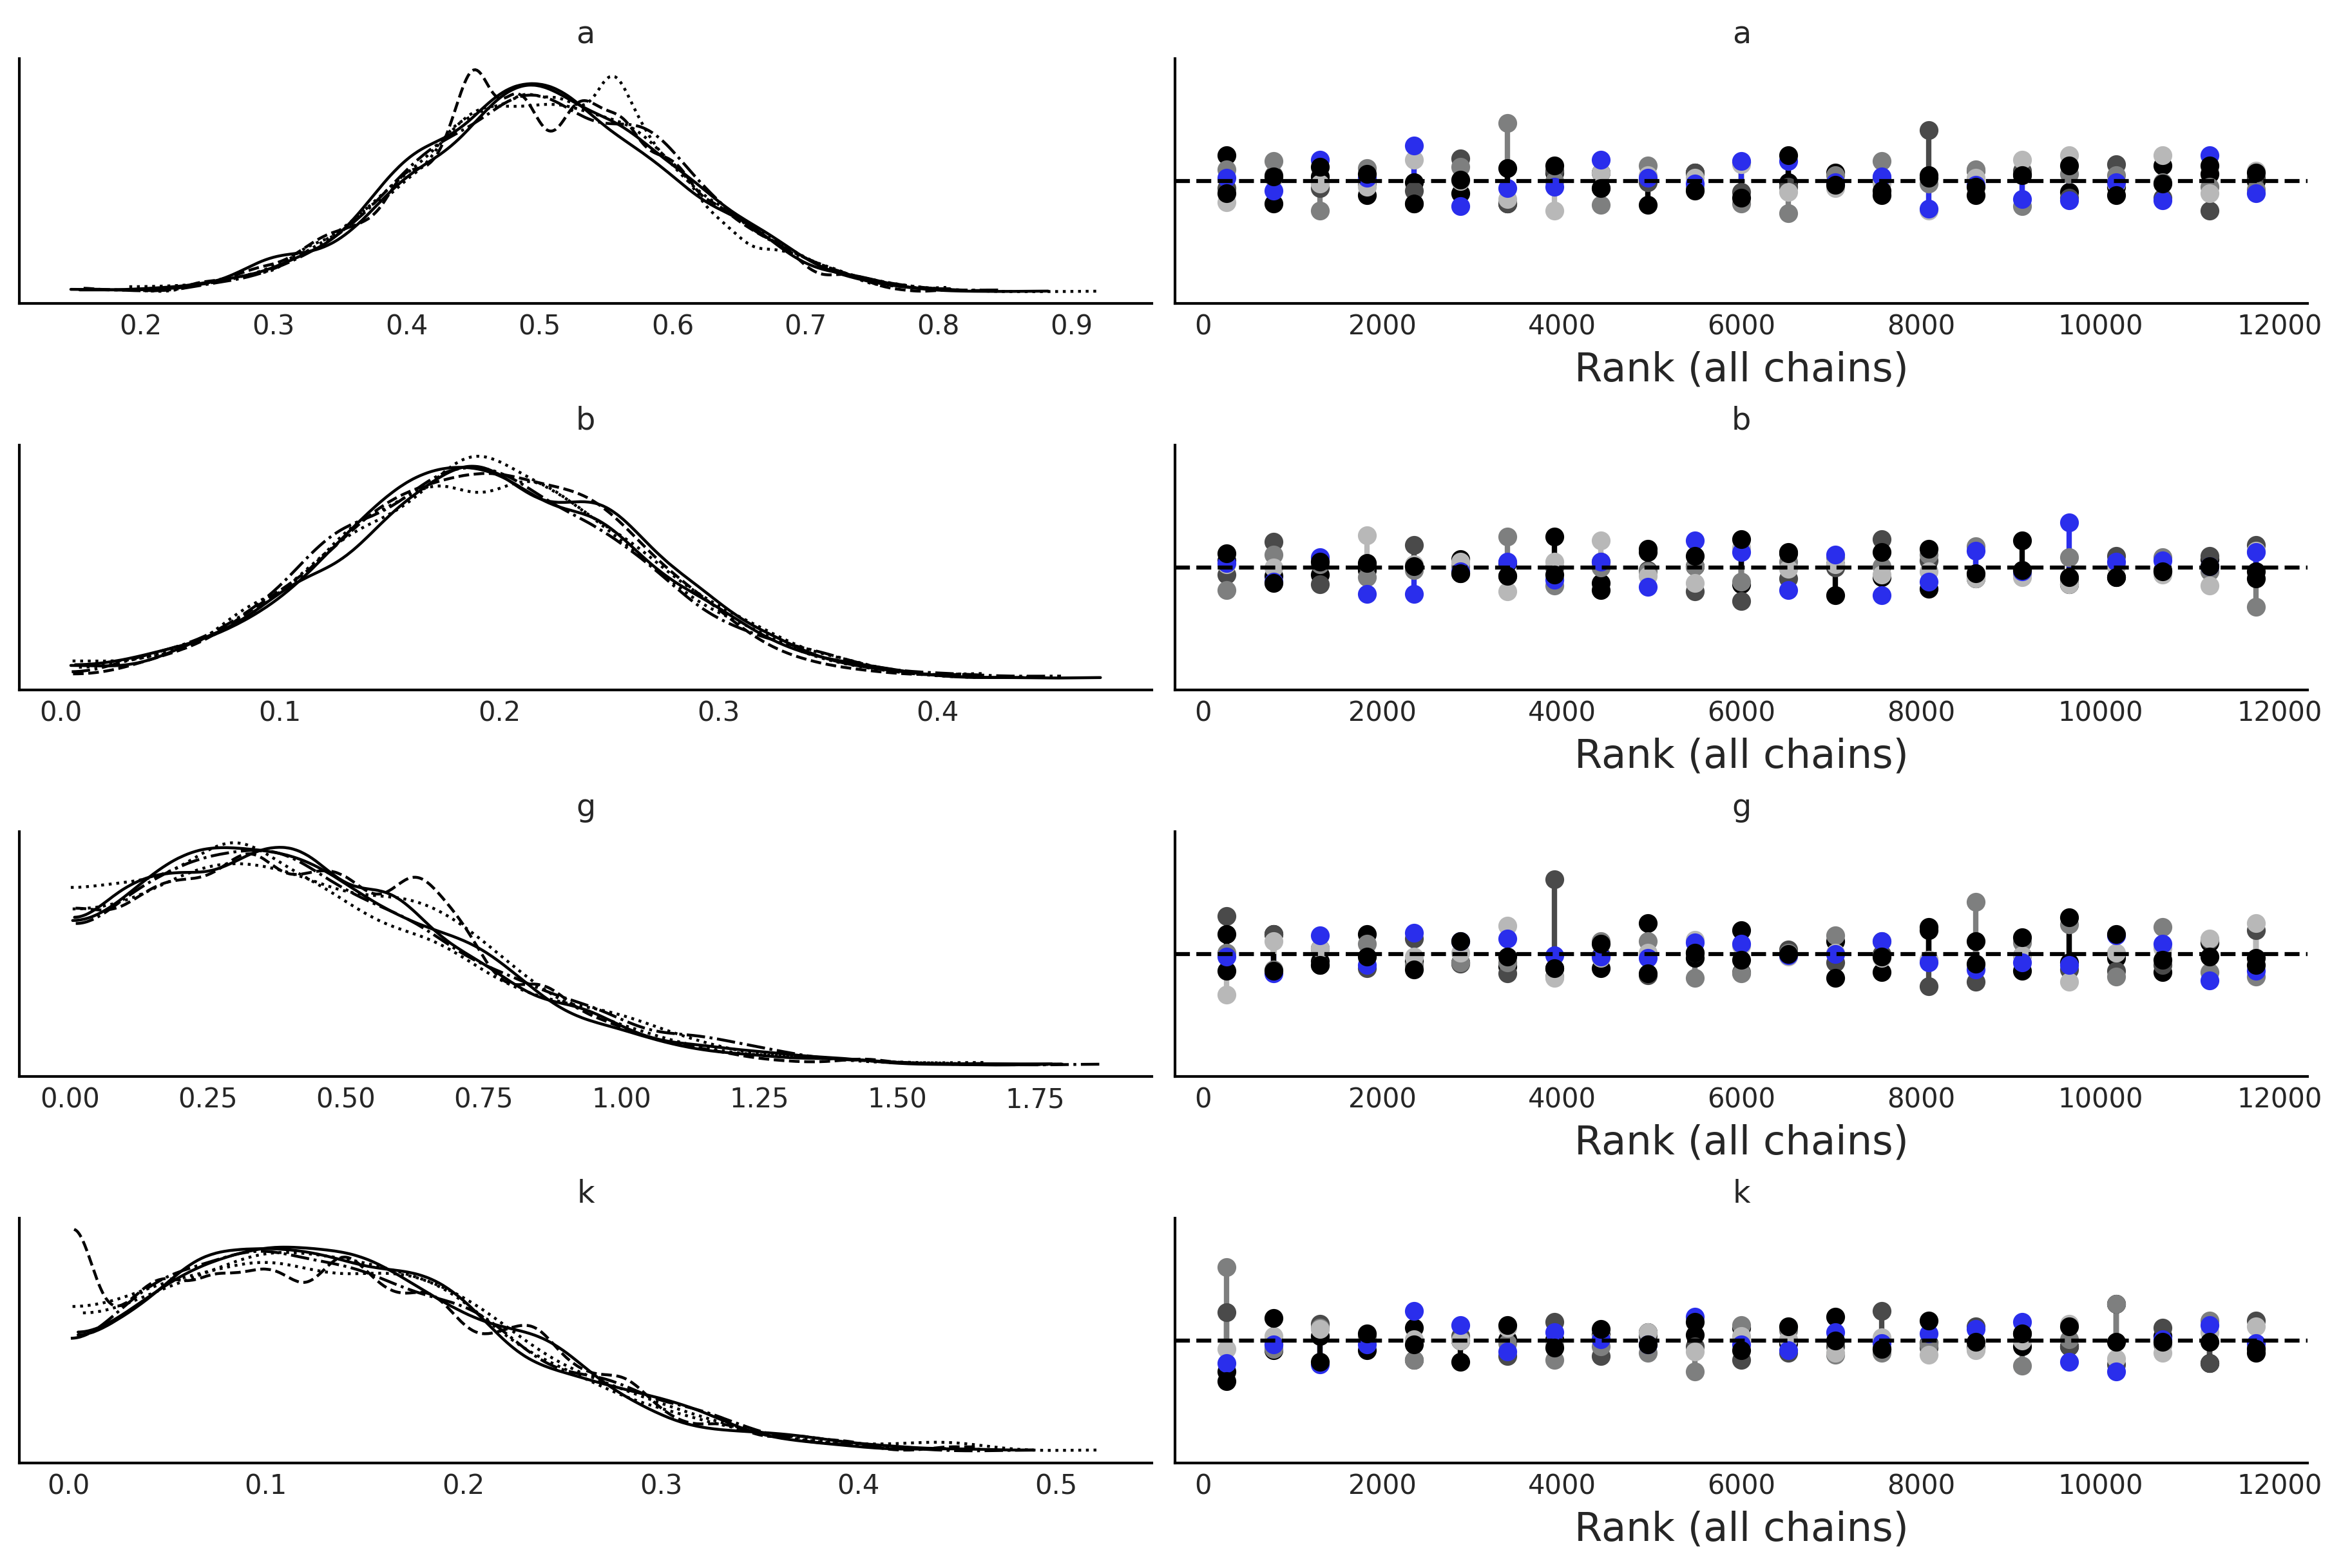

In [29]:
az.plot_trace(trace_gk, kind="rank_vlines");
# plt.savefig("img/chp08/trace_gk.png")

In [30]:
axes = az.plot_pair(trace_gk, 
                    kind="kde", 
                    marginals=True,
                    textsize=45,
                    kde_kwargs={"contourf_kwargs":{"cmap":plt.cm.viridis}},
                    )

for ax, pad in zip(axes[:,0], (70, 30, 30, 30)):
    ax.set_ylabel(ax.get_ylabel(), rotation=0, labelpad=pad)

# plt.savefig("img/chp08/pair_gk.png")

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


### Interpretation
+ Review pair plots


In [31]:
sim_data_gk['s'].shape

(6, 2000, 2484)

In [32]:
means = np.median(sim_data_gk['s'], axis=0)
means.shape

(2000, 2484)

In [33]:
mean_means = np.median(means, axis=0)
mean_means

array([0.5138256 , 0.51590667, 0.51376704, ..., 0.51061573, 0.51111584,
       0.51403959])

In [37]:
# ???? - Get the predicted distribution from the data 
X = np.dstack([sim_data_gk['s'][i]
        for i in range(0,6)])

res = np.mean(np.mean(X, axis=2), axis=0)
df = pd.DataFrame(res).rename(columns={0: 'dailyCO_pred'})

'We have 0 observations larger than 3 ppm'

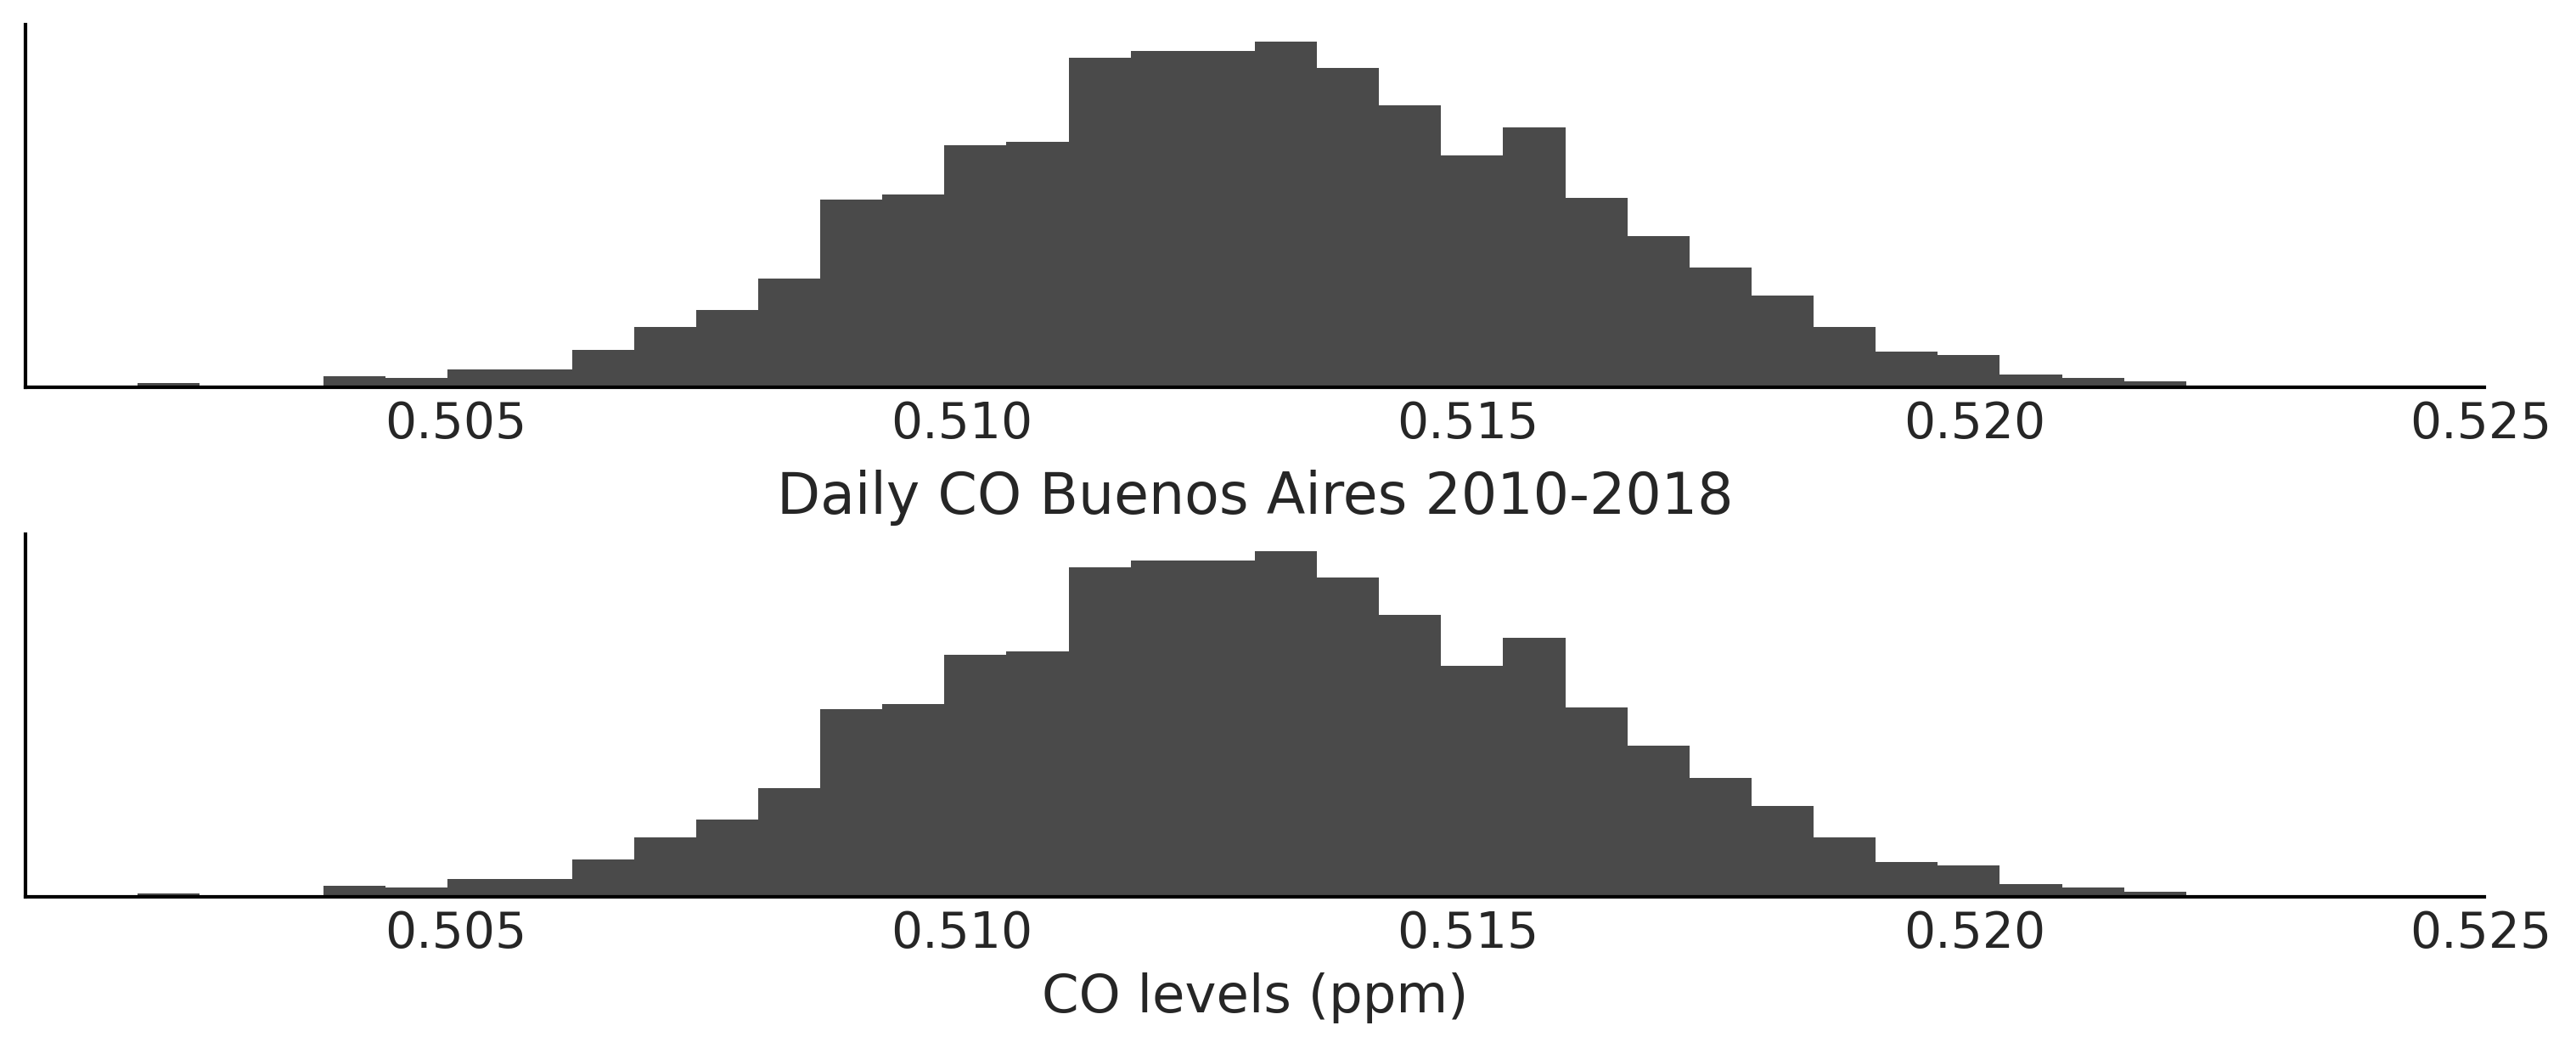

In [38]:
_, axes = plt.subplots(2,1,  figsize=(10,4), sharey=True)
axes[0].hist(mean_means, bins="auto", color="C1", density=True)
axes[0].set_yticks([])
axes[1].hist(mean_means[res < 3], bins="auto", color="C1", density=True)
axes[1].set_yticks([])
axes[1].set_xlabel("CO levels (ppm)")
# plt.savefig("img/chp08/co_ppm_bsas.png")
plt.title('Daily CO Buenos Aires 2010-2018')
f"We have {sum(mean_means > 3)} observations larger than 3 ppm"

In [44]:
octos_pp = np.quantile(res, [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875])
octos_pp

array([0.53903752, 0.54039416, 0.54137069, 0.54225883, 0.54323833,
       0.54429948, 0.54577129])

In [45]:
octos_obs = np.quantile(bsas_co, [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875])
octos_obs

array([0.29732639, 0.3825    , 0.4475    , 0.50791667, 0.57333333,
       0.66041667, 0.798125  ])

# ??? - What happened here - Cannot follow what is returned as simulated data????

## 8.6 Approximating moving averages
+ Next value depends on linear combination of current value and $q$ (order of the Moving Average (MA) model) past values of a stochastic term $\lamba$
+ $y_t = \mu + \lambda_t + \theta_1\lambda_{t-1} + ... + \theta_q\lambda_{t-g}$
+ MA(2) Model
    + $y_t = \lambda_t + \theta_1\lambda_{t-1} + \theta_2\lambda_{t-2}$
    + Simulator below `moving_average`

In [46]:
def moving_average_2(θ1, θ2, n_obs=200):
    λ = np.random.normal(0, 1, n_obs+2)
    y = λ[2:] + θ1*λ[1:-1] + θ2*λ[:-2]
    return y

We are calling the simulator one more time to generate "observed data".

In [47]:
θ1_true = 0.7
θ2_true = 0.3
y_obs = moving_average_2(θ1_true, θ2_true)

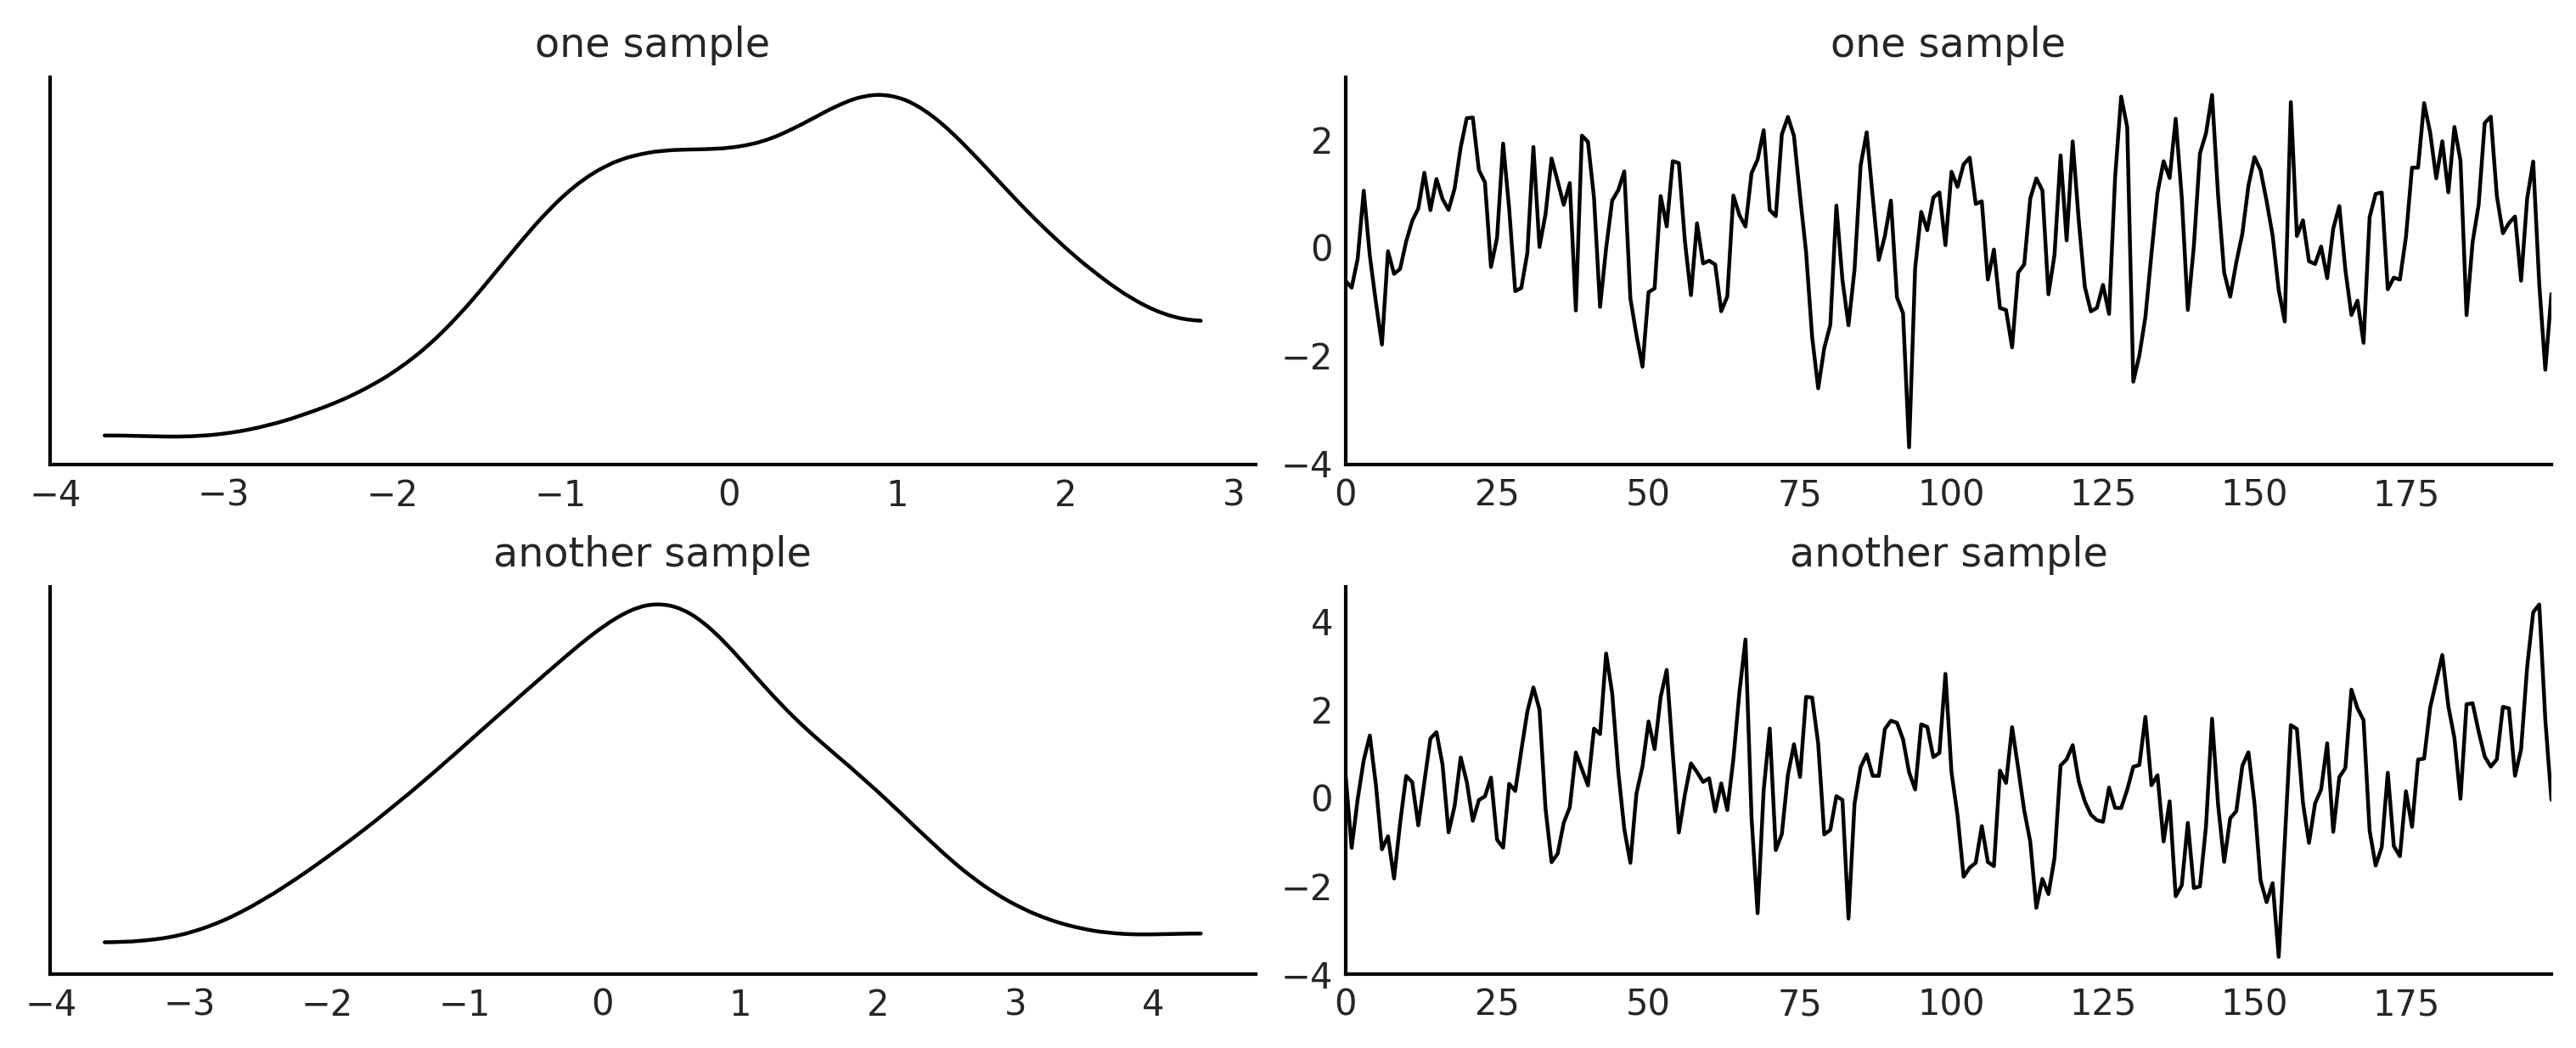

In [48]:
az.plot_trace({'one sample':moving_average_2(θ1_true, θ2_true),
               'another sample':moving_average_2(θ1_true, θ2_true)},
              trace_kwargs={'alpha':1},
              figsize=(10, 4)
             );
# plt.savefig("img/chp08/ma2_simulator_abc.png")

### 2 Samples from MA(2) Model - $\theta1=0.6$ & $\theta2=0.2$ | left: KDE ; right: time series

### Distance Function
+ Instead of using a distance function, use property of MA models i.e. autocorrelation
+ For MA(q) model lags larger than q will be zero, so use autocorrelation for lag=1, and lag=2
+To avoid somputing variance, use auto covariance function
### Constraints
+ For MA(2)
    + $-2 < \theta_1 < 2$
    + $\theta_1 + \theta_2 > -1$
    + $\theta_1 - \theta_2 < 1$
    + This means we need to sample from a triangle as shown in next figure

In [51]:
def autocov(x):
    a = np.mean(x[1:] * x[:-1])
    b = np.mean(x[2:] * x[:-2])
    return np.array((a, b))

##### Code 8.10 and Figure 8.13

In [52]:
with pm.Model() as model_ma2:
    θ1 = pm.Uniform('θ1', -2, 2)
    θ2 = pm.Uniform('θ2', -1, 1)
    # Potential incorporates arbitrary terms in the model without adding new variables
    # useful for restrictions ? does this mean constraints ?
    p1 = pm.Potential("p1", pm.math.switch(θ1+θ2 > -1, 0, -np.inf))
    p2 = pm.Potential("p2", pm.math.switch(θ1-θ2 < 1, 0, -np.inf))

    y = pm.Simulator('y', moving_average_2,
                     params=[θ1, θ2],
                     sum_stat=autocov,
                     epsilon=0.1,
                     observed=y_obs)

    trace_ma2 = pm.sample_smc(draws=3000, kernel="ABC", parallel=True, chains=4)

Initializing SMC sampler...
Sampling 4 chains in 6 jobs
Potentials will be added to the prior term
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


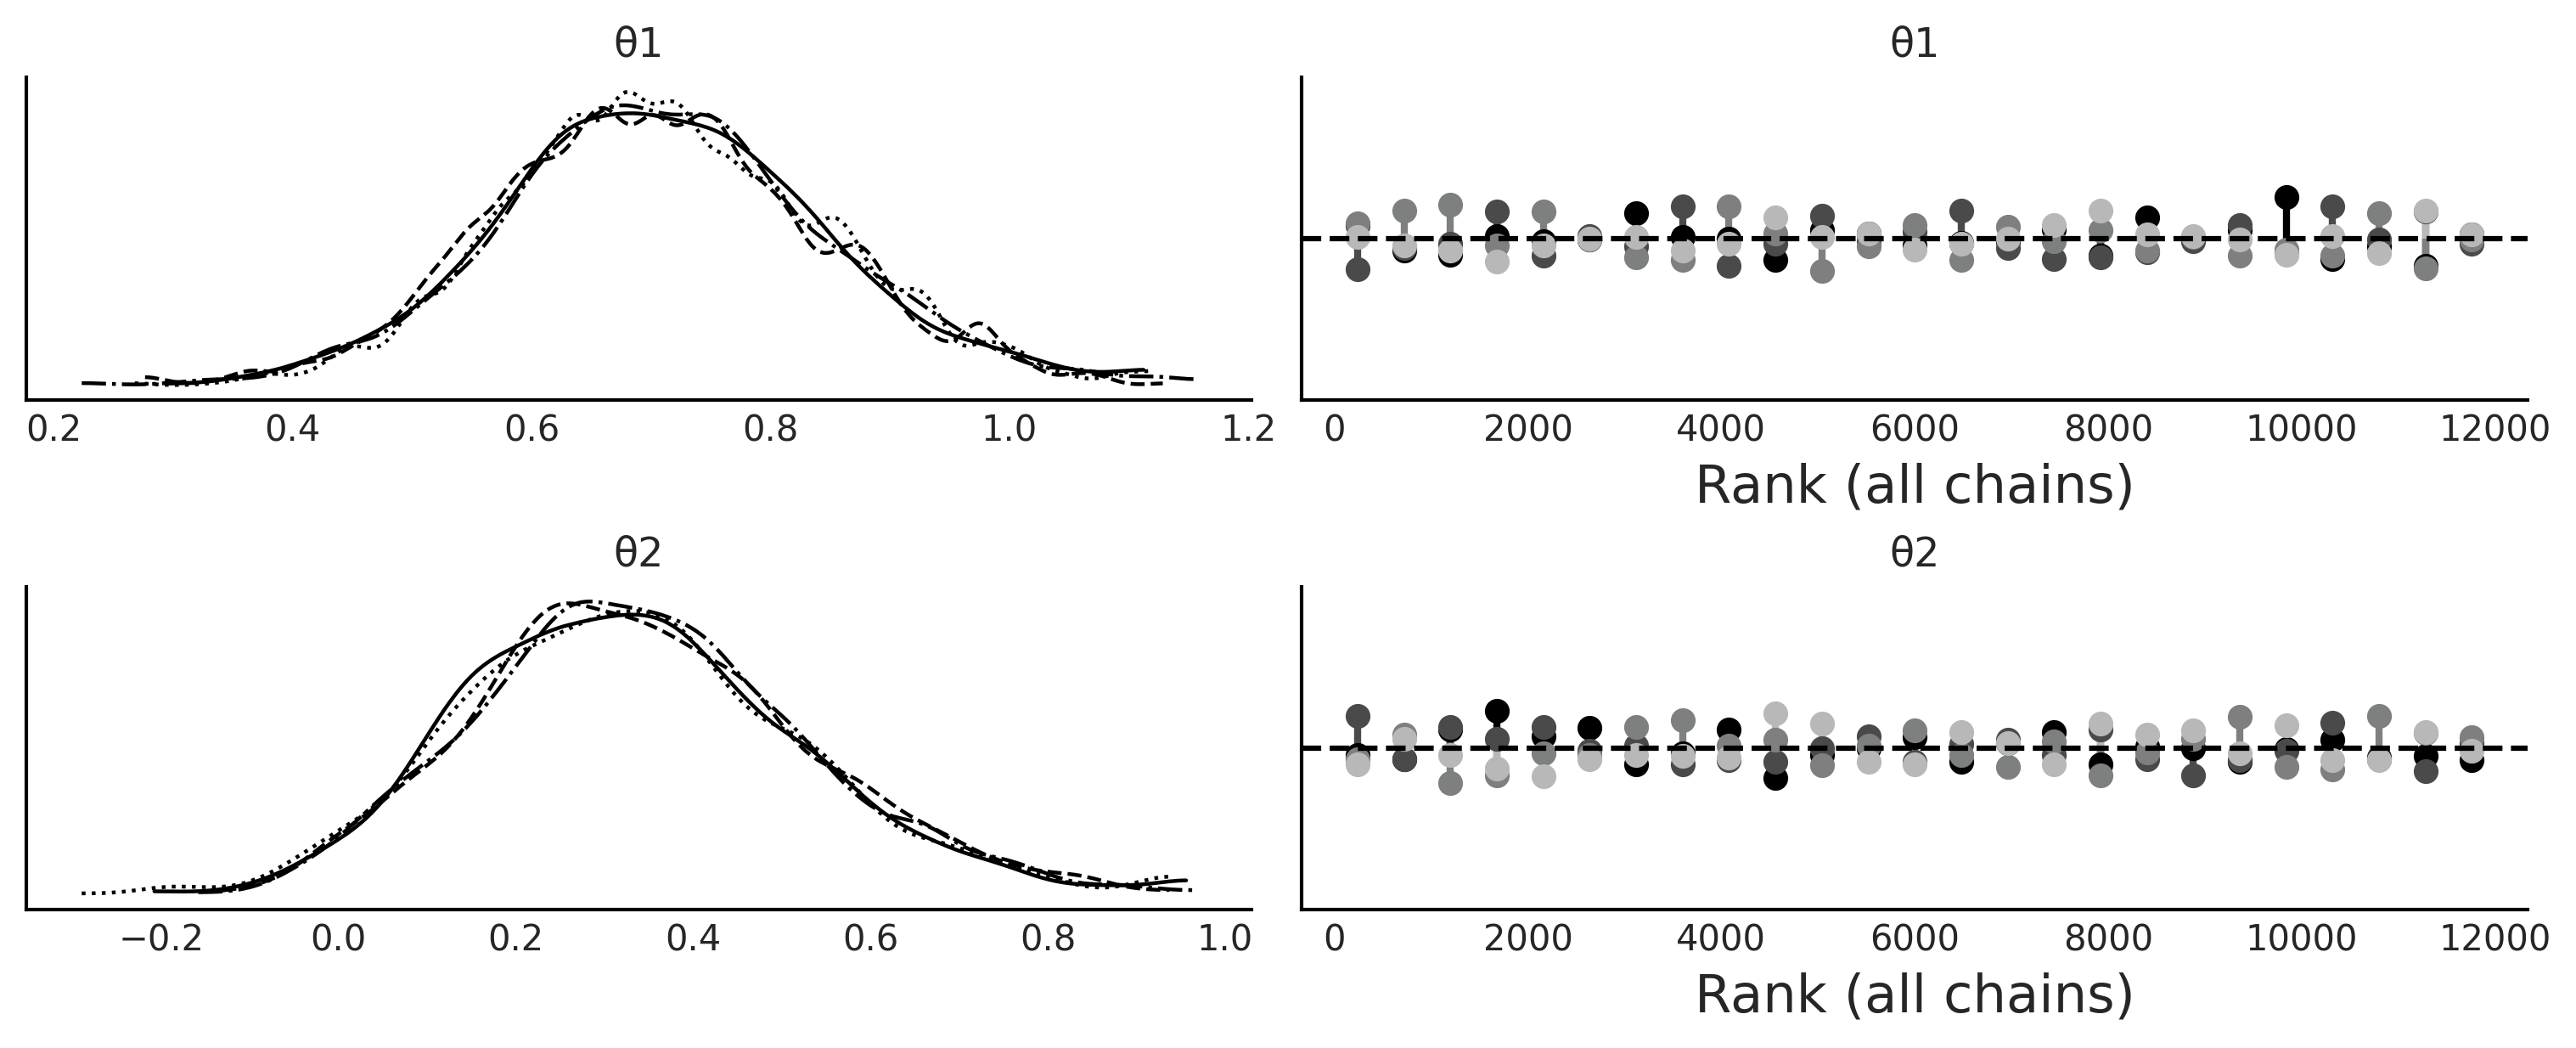

In [54]:
az.plot_trace(trace_ma2, kind="rank_vlines", figsize=(10, 4));
# plt.savefig("img/chp08/ma2_trace.png")

### Trace plot for MA(2) Model
+ True parameters are recovered
+ Rank plots look satisfactorily flat

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


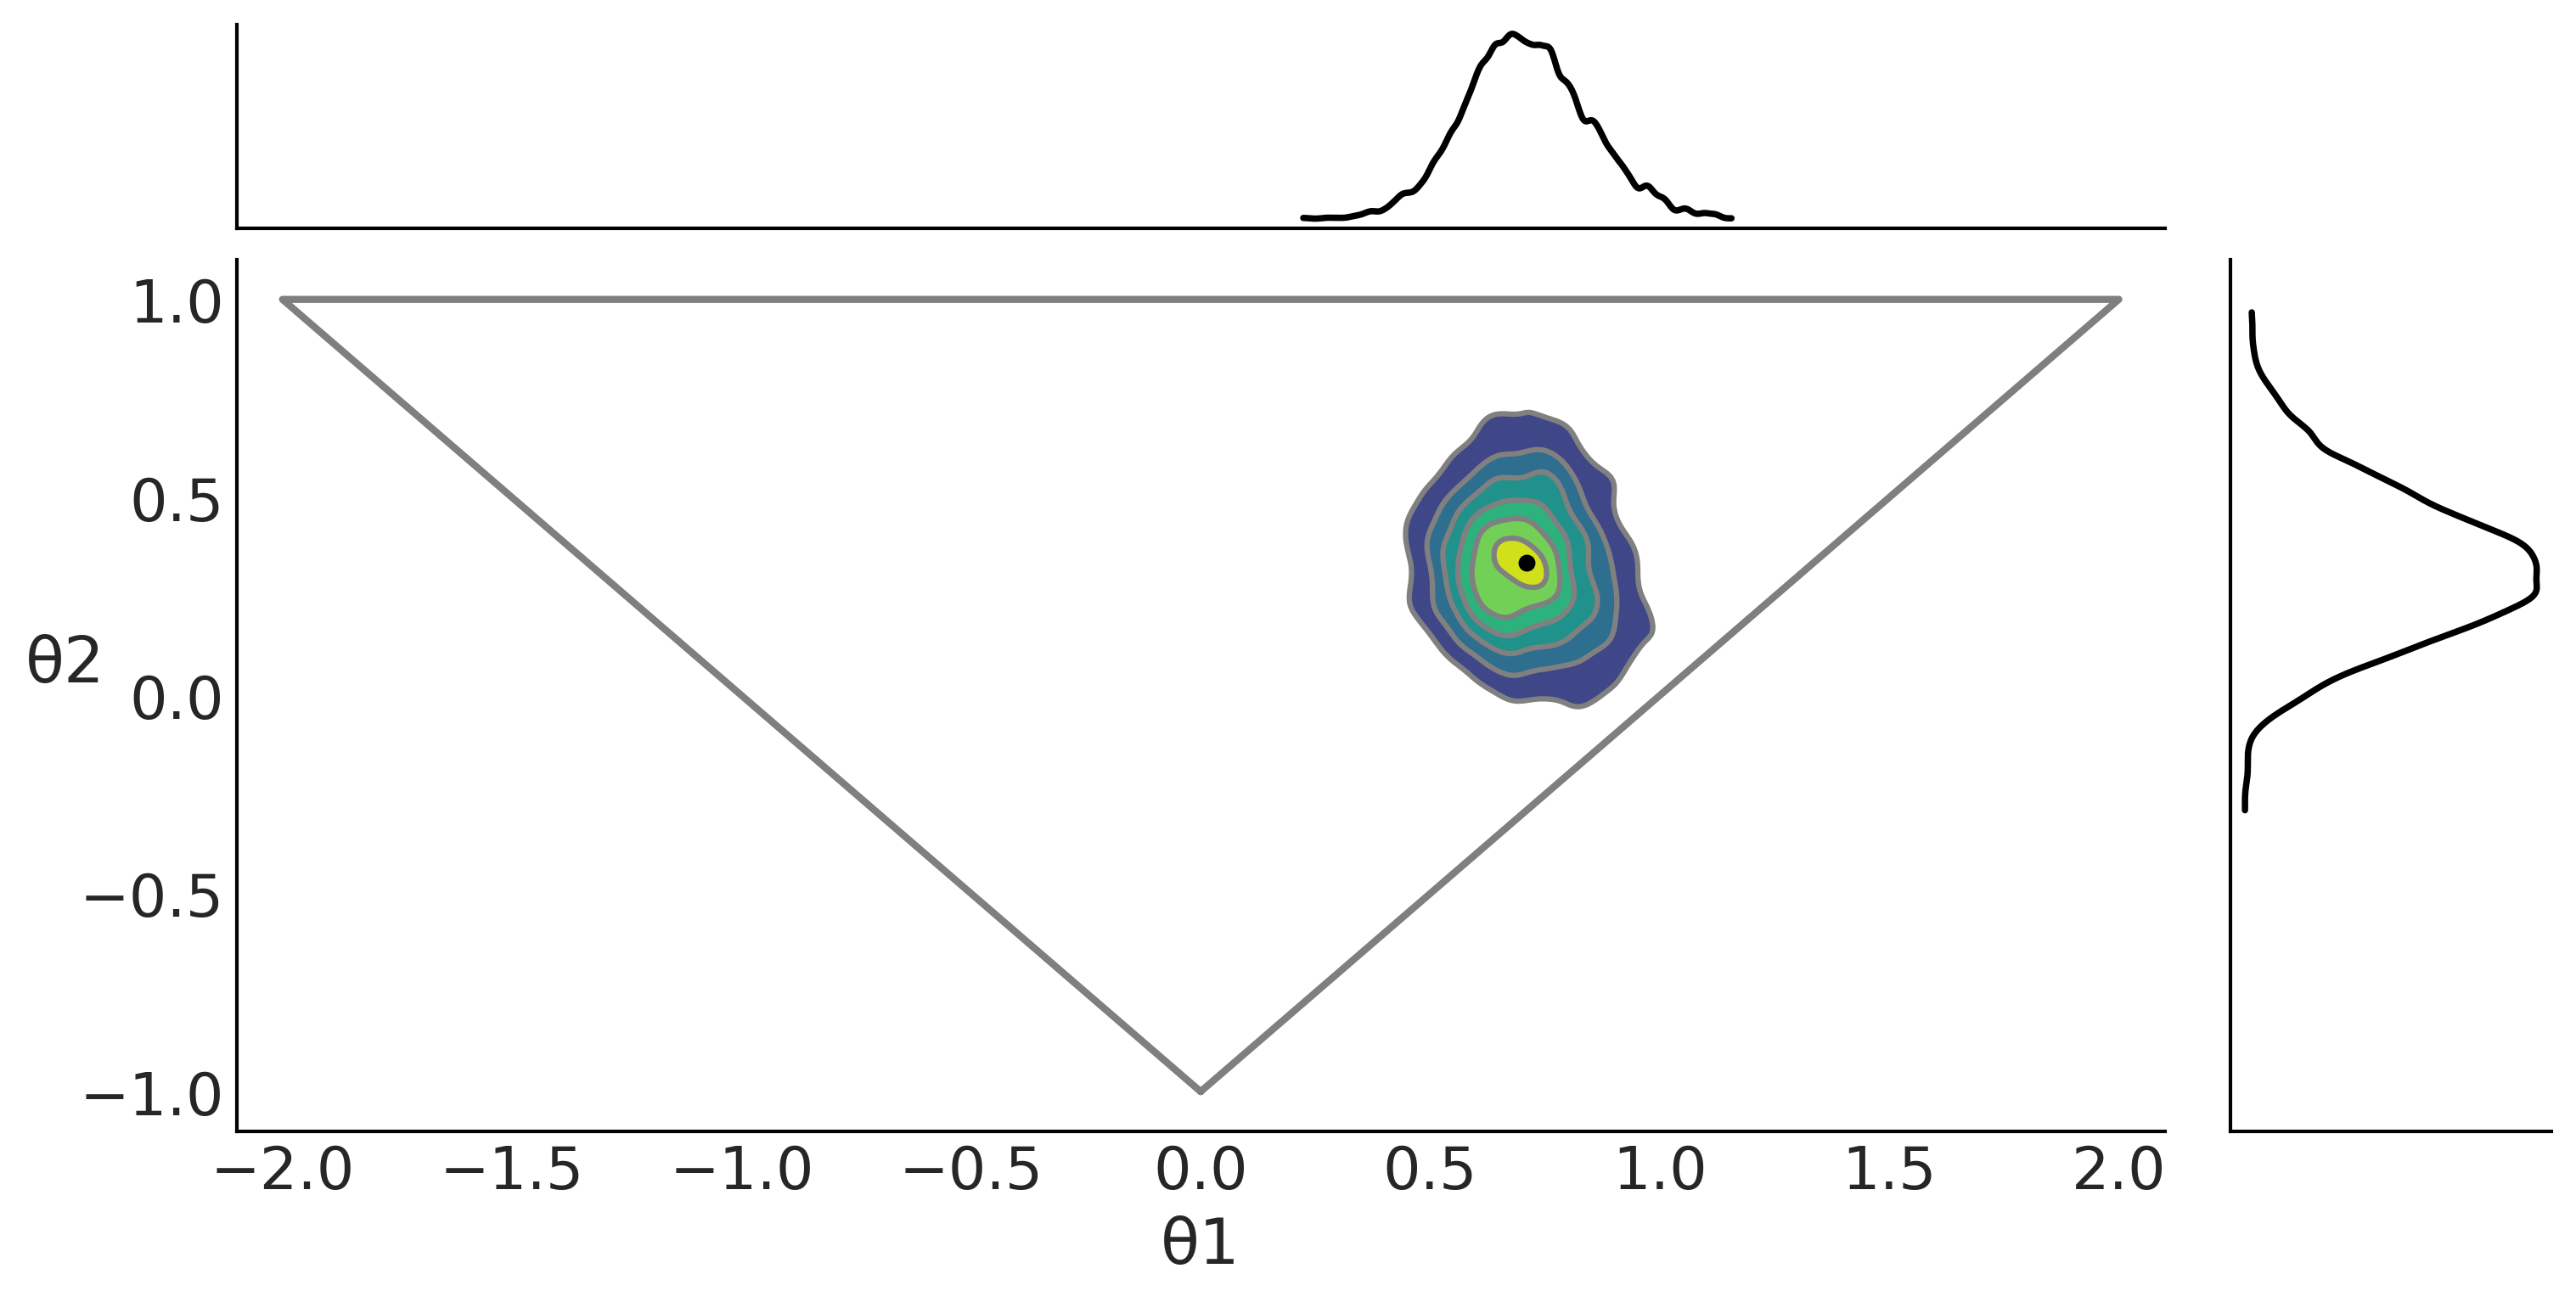

In [56]:
#ax = az.plot_pair(t_p, var_names=["θ1", "θ2"], marginals=True)
axes = az.plot_pair(trace_ma2, kind="kde", var_names=["θ1", "θ2"],
                    marginals=True, figsize=(10,5),
                    kde_kwargs={"contourf_kwargs":{"cmap":plt.cm.viridis}},
                    point_estimate="mean",
                    point_estimate_kwargs={"ls":"none"},
                    point_estimate_marker_kwargs={"marker":".",
                                                  "facecolor":"k",
                                                  "zorder":2})

axes[1,0].set_xlim(-2.1, 2.1)
axes[1,0].set_ylim(-1.1, 1.1)
axes[1,0].set_ylabel(axes[1,0].get_ylabel(), rotation=0)
axes[1,0].plot([0, 2, -2, 0], [-1, 1, 1, -1], "C2", lw=2)
# plt.savefig("img/chp08/ma2_triangle.png")
plt.show();

### ABC posterior for MA(2) model
+ Joint distribution is colored. Mean shown with a black dot
+ marginal distributions for $\theta1$ and $\theta2$ shown
+ Gray triangle represents the prior distribution

## 8.7 Model Comparison in the ABC context
+ Discussion below of 2 approaches
    + Bayes factors
    + Random Forest
   

To reproduce the figures in the book, run `loo_abc.py`

##  Model choice via random forest

In [ ]:
def moving_average_1(θ1, n_obs=500):
    λ = np.random.normal(0, 1, n_obs+1)
    y = λ[2:] + θ1*λ[1:-1]
    return y

def moving_average_2(θ1, θ2, n_obs=500):
    λ = np.random.normal(0, 1, n_obs+2)
    y = λ[2:] + θ1*λ[1:-1] + θ2*λ[:-2]
    return y

θ1_true = 0.7
θ2_true = 0.3
y_obs = moving_average_2(θ1_true, θ2_true)

In [ ]:
def autocov(x, n=2):
    return np.array([np.mean(x[i:] * x[:-i]) for i in range(1, n+1)])

### Code 8.12

In [ ]:
with pm.Model() as model_ma1:
    θ1 = pm.Uniform('θ1', -1, 1)
    y = pm.Simulator('y', moving_average_1,
                     params=[θ1], sum_stat=autocov, epsilon=0.1, observed=y_obs)
    trace_ma1 = pm.sample_smc(3000, kernel="ABC", parallel=True)

In [ ]:
with pm.Model() as model_ma2:
    θ1 = pm.Uniform('θ1', -2, 2)
    θ2 = pm.Uniform('θ2', -1, 1)
    p1 = pm.Potential("p1", pm.math.switch(θ1+θ2 > -1, 0, -np.inf))
    p2 = pm.Potential("p2", pm.math.switch(θ1-θ2 < 1, 0, -np.inf))

    y = pm.Simulator('y', moving_average_2,
                     params=[θ1, θ2],
                     sum_stat=autocov,
                     epsilon=0.1,
                     observed=y_obs)

    trace_ma2 = pm.sample_smc(3000, kernel="ABC", parallel=True)

In [ ]:
mll_ma2 = np.exp(trace_ma2.report.log_marginal_likelihood.mean())
mll_ma1 = np.exp(trace_ma1.report.log_marginal_likelihood.mean())

mll_ma2/mll_ma1

### Code 8.13

In [ ]:
idata_ma1 = az.from_pymc3(trace_ma1)
lpll = {"s":np.array(trace_ma1.report.log_pseudolikelihood)}
idata_ma1.log_likelihood = az.data.base.dict_to_dataset(lpll)

idata_ma2 = az.from_pymc3(trace_ma2)
lpll = {"s":trace_ma2.report.log_pseudolikelihood}
idata_ma2.log_likelihood = az.data.base.dict_to_dataset(lpll)


cmp = az.compare({"model_ma1":idata_ma1, "model_ma2":idata_ma2})
cmp

### Code 8.14

In [ ]:
from functools import partial
select_model([(model_ma1, trace_ma1), (model_ma2, trace_ma2)], 
             statistics=[partial(autocov, n=6)],
             n_samples=10000,
             observations=y_obs)